
## webdatasetとは

[webdataset](https://github.com/webdataset/webdataset)とは，データセットをtarアーカイブで読み書きするためのライブラリです．

> WebDataset reads dataset that are stored as tar files, with the simple convention that files that belong together and make up a training sample share the same basename.

つまり，tarファイルの中に

```text:
n01440764/ILSVRC2012_val_00000293.cls
n01440764/ILSVRC2012_val_00000293.jpg
n01440764/ILSVRC2012_val_00002138.cls
n01440764/ILSVRC2012_val_00002138.jpg
n01440764/ILSVRC2012_val_00003014.cls
n01440764/ILSVRC2012_val_00003014.jpg
```

というファイルが入っていたら，同じbasenameを持つ複数のファイルを1つの学習サンプルデータとみなします（最初のサンプルの場合には`n01440764/ILSVRC2012_val_00000293`ががbasename）．この場合には3つの学習データがあり，jpgとclsというペアが1つのサンプルになっています．

この形式は，PyTorchのtorchdataやNVIDIAのdaliなども読み込みを対応しています．

- [torchdata.datapipes.iter.WebDataset](https://pytorch.org/data/main/generated/torchdata.datapipes.iter.WebDataset.html)
- [nvidia.dali.fn.readers.webdataset](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/general/data_loading/dataloading_webdataset.html)

大量のデータを扱う場合にはtarで固めておいたほうが便利なときも多いので，使い方次第でいろいろ工夫ができます．が，英語でも日本語でもほとんど使い方の情報がありません．見つかったとしても，tarアーカイブを作るには`tar`や`tarp`を使えばよい，読み込みもjpgとclsというペアのサンプルしかない，など，工夫を凝らしたshard作成やデコーダを作成するには情報が足りません．

- [PyTorchで深層学習データセットを効率的に取り扱うために](https://cyberagent.ai/blog/research/14632/)
- [1ペタバイトのデータセットで機械学習する / WebDataset入門](https://zenn.dev/turing/articles/petabyte_webdataset)
- [git@github.com:tmbdev-archive/webdataset-examples.git](https://github.com/tmbdev-archive/webdataset-examples)


そこでこの記事では，いろいろなshardの生成方法や，デコーダなどの作成方法を紹介することにします．








### ちなみにtarとは？

- [tarとは - 意味をわかりやすく - IT用語辞典 e-Words](https://e-words.jp/w/TAR.html)
- [「分かりそう」で「分からない」でも「分かった」気になれるIT用語辞典](https://wa3.i-3-i.info/word14224.html)





# webdatasetのインストール

まずはpipでwebdatasetをインストールします．

In [ ]:
!pip install git+https://github.com/webdataset/webdataset.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/webdataset/webdataset.git to /tmp/pip-req-build-up9_m1oz
  Running command git clone -q https://github.com/webdataset/webdataset.git /tmp/pip-req-build-up9_m1oz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


もしくは普通にpipから．

In [ ]:
!pip install webdataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 3.0 MB/s 


webdatasetのインポートではwdsと略します．

In [ ]:
import webdataset as wds

# データの準備

では例題用の学習データを用意します．小さいtoy exampleがよいので，ここではImageNetのサブセットである[imagenette](https://github.com/fastai/imagenette)の最小画像サイズを利用します．

In [ ]:
import requests
from pathlib import Path
import tarfile

def download(url):
    filename = Path(url).name
    with open(filename, 'wb') as save_file:
        save_file.write(requests.get(url).content)
    return filename

def tar_xzvf(filename, path='.'):
    with tarfile.open(filename, 'r:gz') as tar_file:
        tar_file.extractall(path=path)

def tar_tvf(filename):
    with tarfile.open(filename, 'r:') as tar_file:
        for i in range(10):
            info = tar_file.next()
            print(f'{info.gname}/{info.uname} {info.size:8d} {info.name}')

In [ ]:
filename = download('https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz')
tar_xzvf(filename)

これで`./imagenette2-160/train/`以下に学習画像が保存されました．

# pytorch標準のデータローダーの復習

では通常のpytorchのデータローダーの典型例を書いてみましょう．

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

単純にImageFolderを使った場合，`root`に画像フォルダを指定すれば，それ以下のサブフォルダはカテゴリとみなされてラベルは自動的に生成されます．

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = ImageFolder(
    './imagenette2-160/train/',
    transform=transform)

In [ ]:
for i, (img, label) in enumerate(dataset):
    print(img.shape, label)
    if i > 5:
        break

torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0


データローダーを使った場合．こちらが普通ですね．

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    )

In [ ]:
for i, (img, label) in enumerate(data_loader):
    print(img.shape, label)
    if i > 5:
        break

torch.Size([4, 3, 224, 224]) tensor([4, 7, 8, 6])
torch.Size([4, 3, 224, 224]) tensor([6, 5, 4, 0])
torch.Size([4, 3, 224, 224]) tensor([7, 9, 0, 5])
torch.Size([4, 3, 224, 224]) tensor([0, 9, 7, 3])
torch.Size([4, 3, 224, 224]) tensor([2, 8, 6, 9])
torch.Size([4, 3, 224, 224]) tensor([2, 2, 1, 0])
torch.Size([4, 3, 224, 224]) tensor([7, 3, 2, 7])


# webdatasetのshardの作り方

では同じものをwebdatasetでやってみます．

まずはデータの準備です．上記のような構造のフォルダに保存されている画像を読み込んで，複数のtarファイルにまとめていきます．ちなみにそれぞれのそれぞれのtarファイルをshard（断片）と呼びます．

shardを作ったらローダーを作りますが，まずshardをどのように作成するのかを説明しましょう．準備として，以下のようにjpeg画像ファイルのリストと，カテゴリ名のリストを作成します．

In [ ]:
import os
import random

dataset_root = './imagenette2-160/train/'

file_paths = [
    path for path in Path(dataset_root).glob('*/*')
    if not path.is_dir() 
        and path.name.endswith((
            '.JPEG', '.jpeg', '.jpg',
        ))
]
random.shuffle(file_paths)

print(file_paths[:2])

category_list = sorted([
    path.name for path in Path(dataset_root).glob('*') if path.is_dir()
    ])
category_index = {
    category_name: i 
    for i, category_name in enumerate(category_list)
    }

category_index

[PosixPath('imagenette2-160/train/n02102040/n02102040_3699.JPEG'), PosixPath('imagenette2-160/train/n03425413/n03425413_12249.JPEG')]


{'n01440764': 0,
 'n02102040': 1,
 'n02979186': 2,
 'n03000684': 3,
 'n03028079': 4,
 'n03394916': 5,
 'n03417042': 6,
 'n03425413': 7,
 'n03445777': 8,
 'n03888257': 9}

後にも説明しますが，shardに書き込む時点でランダムにしておいたほうが都合が良いです．そのためそのため`file_paths`をここでシャッフルしています．

## shard作成方法1

ではshardを書き出します．
まずは，画像ファイルを読み込み，ndarrayにしてから，webdatasetのjpegエンコーダを利用する方法です．

In [ ]:
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
import json

shard_path = './shards_01'

shard_dir_path = Path(shard_path)
shard_dir_path.mkdir(exist_ok=True)
shard_filename = str(shard_dir_path / 'shards-%05d.tar')

shard_size = int(50 * 1000**2)  # 50MB each

with wds.ShardWriter(
    shard_filename,
    maxsize=shard_size,
    ) as sink, tqdm(
        file_paths
    ) as pbar:

    for file_path in pbar:

        category_name = file_path.parent.name
        label = category_index[category_name]
        key_str = category_name + '/' + file_path.stem

        sink.write({
            "__key__": key_str,
            "jpg": np.array(Image.open(file_path)),
            "cls": label,
        })

dataset_size = len(shard_filename)

dataset_size_filename = str(
    shard_dir_path / 'dataset-size.json')
with open(dataset_size_filename, 'w') as fp:
    json.dump({
        "dataset size": dataset_size,
        "n_classes": len(category_index),
    }, fp)

# writing shards_01/shards-00000.tar 0 0.0 GB 0


  0%|          | 0/9469 [00:00<?, ?it/s]

# writing shards_01/shards-00001.tar 2363 0.1 GB 2363
# writing shards_01/shards-00002.tar 2375 0.1 GB 4738
# writing shards_01/shards-00003.tar 2425 0.1 GB 7163


### shard作成の詳しい説明

これ以降の例は上記のコードをベースにしているので，ここで詳しく順を追って説明します．

```python:
shard_path = './shards_01'

shard_dir_path = Path(shard_path)
shard_dir_path.mkdir(exist_ok=True)
shard_filename = str(shard_dir_path / 'shards-%05d.tar')
```

shardを保存するディレクトリとファイル名を設定します．[`pathlib`](https://docs.python.org/ja/3/library/pathlib.html)を使っているのでので見慣れないかもしれませんが，ディレクトリを作成して，ファイル名文字列を生成しているだけです．shardファイルは複数生成されるので，文字列には出力指定子を使います．


```python:
shard_size = int(50 * 1000**2)  # 50MB each

with wds.ShardWriter(
    shard_filename,
    maxsize=shard_size,
    ) as sink, tqdm(
        file_paths
    ) as pbar:
```

`with`文で`ShardWriter`を生成します．

- 1つ目の引数は出力指定子付きの保存ファイル名パターンを指定子ます．
- 2つ目の`maxsize`には，一つのshard（tarファイル）のサイズを指定します（バイト単位）．たとえばshardにまとめるデータが130MBあった場合，maxsizeを50MBにすると，50MB, 50MB, 30MBという3つのtarファイルが生成されます．

ファイル保存の進捗を表示したいので，`tqdm`も使います．（同時に`with`で指定しています）

```python:
    for file_path in pbar:

        category_name = file_path.parent.name
        label = category_index[category_name]
        key_str = category_name + '/' + file_path.stem
```

ここでは文字列操作をしています．．
- `category_name`には，フルパスのファイル名から，カテゴリ名であるディレクトリ名を抜き出して保存しています．
- `label`には，カテゴリ番号のintを保存します．．
- `key_str`には，tarファイル中ののbasenameとなる文字列を指定子ます．`file_path.stem`だけでも良いのですが，ここではカテゴリ名も付け加えておきます．


```python:
        sink.write({
            "__key__": key_str,
            "jpg": np.array(Image.open(file_path)),
            "cls": label,
        })
```

この部分が実際にtarファイルに追記する部分です．`write`にはdict型を与えます．dictには`"__key__"`というキーが必須です．この値が，tarファイル中のbasenameになります．

それ以外のキー（指定の仕方については後述します）は，tarファイル中の拡張子として使用されます．上記の例で

```text:
category_name == "n01440764"
file_path.stem == "ILSVRC2012_val_00000293"
key_str == "n01440764/ILSVRC2012_val_00000293"
```

となっているとすると，

```text:
n01440764/ILSVRC2012_val_00000293.jpg
n01440764/ILSVRC2012_val_00000293.cls
```

という2つのファイルがtarファイル中に書き込まれることになります．

これを，学習サンプルの文だけ反復します．
tarファイルにどんどんとサンプルを追加していきますが，`maxsize`を超えると，そのtarファイルはクローズされて，次からはカウンタが一つ増えた新しいtarファイルに追加していきます．

ここまでがshardであるtarファイルの作成方法です．

```python:
dataset_size = len(shard_filename)

dataset_size_filename = str(
    shard_dir_path / 'dataset-size.json')
with open(dataset_size_filename, 'w') as fp:
    json.dump({
        "dataset size": dataset_size,
        "n_classes": len(category_index),
    }, fp)
```

最後に，データセット中の学習サンプル数（dataset size）を別途保存しておきます．形式は何でも良いのですが，ここでは例としてjsonで保存しています．

webdatasetのshardをロードするときには，サンプル数を明示的に与える必要があります．もし`ImageFolder`などを使うディレクトリ中のファイルをカウントすればサンプル数が分かるので，与える必要はありません．しかしwebdatasetの場合には，学習データは複数のshardに分かれていて，さらに各tarファイルの中にはいくつのサンプルが含まれているのかは，すべて読み込んでからでなければ分かりません（これではtarから読み込みながらその都度学習，ということができません）．


### shardの書き込みに使うキー

`write`に与えるdictのキーにはいくつかのルールがあります．

- `__key__`：必須．basenameとして使用されます（前述の通り）

それ以外のキーは，以下のように解釈されます．

#### JPEG, PNGなど画像の拡張子

imgが`PIL.Image`や`np.ndarray`の場合には，キーに指定したフォーマットの画像にエンコードされます．例えば

```python:JPEG画像
sink.write({
    "__key__": key_str,
    "jpg": img,
    })
```

ならjpeg画像ファイルとしてtarに書き込まれますし，

```python:PNG画像
sink.write({
    "__key__": key_str,
    "png": img,
    })
```

ならpng画像ファイルになります．つまりキーは，tarに書き込まれるファイルの拡張子になるだけでなく，エンコーダへのヒントとしても使われます．

#### その他のキー

- `cls`: webdatasetのサンプルコードでよく出てくるのは`"cls"`ですが，この場合には値は単に文字列としてファイルに保存されます．
- `pickle`: このキーで指定されたオブジェクトはpickleファイルとして書き込まれます．

ドキュメントには説明が見当たらないですが，[コードを見れば](https://github.com/webdataset/webdataset/blob/4dd1f4b47d743e06d6f385343fd4b5a81ecbecde/webdataset/writer.py#L139)どんなキーが使えるのかがわかります．

```python:writer.py
def make_handlers():
    """Create a list of handlers for encoding data."""
    handlers = {}
    add_handlers(
        handlers, "cls cls2 class count index inx id", lambda x: str(x).encode("ascii")
    )
    add_handlers(handlers, "txt text transcript", lambda x: x.encode("utf-8"))
    add_handlers(handlers, "html htm", lambda x: x.encode("utf-8"))
    add_handlers(handlers, "pyd pickle", pickle.dumps)
    add_handlers(handlers, "pth", torch_dumps)
    add_handlers(handlers, "npy", numpy_dumps)
    add_handlers(handlers, "npz", numpy_npz_dumps)
    add_handlers(handlers, "ten tenbin tb", tenbin_dumps)
    add_handlers(handlers, "json jsn", lambda x: json.dumps(x).encode("utf-8"))
    add_handlers(handlers, "mp msgpack msg", mp_dumps)
    add_handlers(handlers, "cbor", cbor_dumps)
    add_handlers(handlers, "jpg jpeg img image", lambda data: imageencoder(data, "jpg"))
    add_handlers(handlers, "png", lambda data: imageencoder(data, "png"))
    add_handlers(handlers, "pbm", lambda data: imageencoder(data, "pbm"))
    add_handlers(handlers, "pgm", lambda data: imageencoder(data, "pgm"))
    add_handlers(handlers, "ppm", lambda data: imageencoder(data, "ppm"))
    return handlers
```

つまりキーに`cls`とかいても`id`と書いても同じ扱いですね．


#### 文字列＋拡張子のキー

キーを`jpg`とすると，`basename + ".jpg"`というjpegファイルがtarに書き込まれますが，キーを`image.jpg`とすると，`basename + "image.jpg"`というjpegファイルがtarに書き込まれます．

つまりキー文字列のsuffix（`.`以降）がフォーマットのヒントとして使われます．一つの学習サンプルが複数のjpeg画像を持つような場合には，例えば`image1.jpg`と`image2.jpg`という2つのキーで2枚の画像を保存します．

なお`.`が複数ある場合には，最初の`.`以前がstemとして（つまりキーとして），最後の`.`以降が拡張子として扱われるようです．あとの例でも出てきますが，`foobar.img.jpg`や`foobar.label.jpg`などのファイルをtarに書き込むと，デコード時には，同じ`foobar`をキーとして持つ2つの画像として扱われます．


#### 用意されていないフォーマットの場合

デフォルトで用意されているのは上記のものだけなので，これら以外のデータを書き込む場合には，pickleオブジェクトにします．

もしくは，バイト列として保存します．どんなキーを使ったとしても，書き込む値の方がbyteオブジェクトであれば，そのままバイト列として保存されるようです．[コードを見ると](https://github.com/webdataset/webdataset/blob/4dd1f4b47d743e06d6f385343fd4b5a81ecbecde/webdataset/writer.py#L178)以下のようになっています．

```python:writer.py
    if isinstance(data, bytes):
        return data
```

これを使うと，書き込みたいファイルが何であれ（例えば動画.mp4や音声.mp3などでも），byteオブジェクトとして読み込み，そのまま書き込むことができます．

```python:動画ファイルの書き込みの例
with open(filename, "rb") as f:
    movie_bytes = f.read()

    sink.write({
        "__key__": key_str,
        "mp4": movie_bytes,
        })
```

なお[webdatasetの`write`の書き込み](https://github.com/webdataset/webdataset/blob/4dd1f4b47d743e06d6f385343fd4b5a81ecbecde/webdataset/writer.py#L354)には[TarFile.add](https://docs.python.org/ja/3/library/tarfile.html)を使っているため，上記の`movie_bytes`には一旦ファイル全体を読み込む必要があります．数百GBのファイルを扱うような場合にはメモリ容量に注意してください．


更に別の方法として，encoderを自作して[コンストラクタに与える](https://github.com/webdataset/webdataset/blob/4dd1f4b47d743e06d6f385343fd4b5a81ecbecde/webdataset/writer.py#L267)という方法もあります．説明は省略するので頑張って自作してください．

```python:writer.py
class TarWriter:
    ...
    def __init__(
        ...
        encoder: Union[None, bool, Callable] = True,
        ...
    ):
```




これでshardができました．`tar`コマンドで中身を見てみましょう．

In [ ]:
tar_tvf('shards_01/shards-00000.tar')

bigdata/bigdata        1 n02102040/n02102040_3699.cls
bigdata/bigdata    17933 n02102040/n02102040_3699.jpg
bigdata/bigdata        1 n03425413/n03425413_12249.cls
bigdata/bigdata    24201 n03425413/n03425413_12249.jpg
bigdata/bigdata        1 n03888257/n03888257_6468.cls
bigdata/bigdata    18911 n03888257/n03888257_6468.jpg
bigdata/bigdata        1 n01440764/n01440764_769.cls
bigdata/bigdata    26733 n01440764/n01440764_769.jpg
bigdata/bigdata        1 n02979186/n02979186_14197.cls
bigdata/bigdata    22348 n02979186/n02979186_14197.jpg


確認のために画像を1枚読み込んで表示してみます．

label: 1


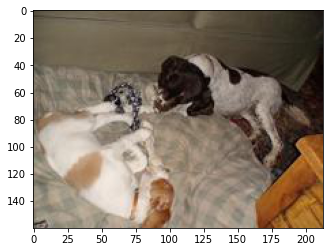

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

shard_filename = 'shards_01/shards-00000.tar'

with tarfile.open(shard_filename, 'r') as tar_file:
    filename = tar_file.next().name
    key = filename.split('.')[0]  # stem
    img_buffer = tar_file.extractfile(key + '.jpg')
    img = np.array(Image.open(img_buffer))
    cls_buffer = tar_file.extractfile(key + '.cls')
    label = int(cls_buffer.read())
plt.imshow(img)
print('label:', label)

上記の読み込みは，webdatasetのデコーダでは自動的に行われる処理が多いので，実際に使用する際には必要はありません．

- `tar_file.extractfile`で読み込むと`io.BufferedReader`が返ってきます
- `PIL.Image.open()`ならそれを直接指定して読み込みます
- `cls`のほうは，`read()`で読んだbytesをintに変換しています





## shard作成方法2

次のshard書き出し方法は，画像ファイルをそのまま何もせずににバイト列のままshardに書き込む方法です．jpegをデコード・エンコードしないので，shard作成が速い・ファイル容量はそのまま，です．

In [ ]:
from tqdm.auto import tqdm
import io

shard_path = './shards_02'

shard_dir_path = Path(shard_path)
shard_dir_path.mkdir(exist_ok=True)
shard_filename = str(shard_dir_path / 'shards-%05d.tar')
print('shards are saved as', shard_filename)

shard_size = int(50 * 1000**2)  # 50MB each

with wds.ShardWriter(
    shard_filename,
    maxsize=shard_size,
    ) as sink, tqdm(
        file_paths
    ) as pbar:

    for file_path in pbar:

        category_name = file_path.parent.name
        label = category_index[category_name]
        key_str = category_name + '/' + file_path.stem

        with open(file_path, 'rb') as raw_bytes:
            buffer = raw_bytes.read()

        sink.write({
            "__key__": key_str,
            "jpg": buffer,
            "cls": label,
        })

dataset_size = len(shard_filename)

dataset_size_filename = str(
    shard_dir_path / 'dataset-size.json')
with open(dataset_size_filename, 'w') as fp:
    json.dump({
        "dataset size": dataset_size,
        "n_classes": len(category_index),
    }, fp)

shards are saved as shards_02/shards-%05d.tar
# writing shards_02/shards-00000.tar 0 0.0 GB 0


  0%|          | 0/9469 [00:00<?, ?it/s]

# writing shards_02/shards-00001.tar 6267 0.1 GB 6267


In [ ]:
tar_tvf('shards_02/shards-00000.tar')

bigdata/bigdata        1 n02102040/n02102040_3699.cls
bigdata/bigdata     6814 n02102040/n02102040_3699.jpg
bigdata/bigdata        1 n03425413/n03425413_12249.cls
bigdata/bigdata     9479 n03425413/n03425413_12249.jpg
bigdata/bigdata        1 n03888257/n03888257_6468.cls
bigdata/bigdata     7363 n03888257/n03888257_6468.jpg
bigdata/bigdata        1 n01440764/n01440764_769.cls
bigdata/bigdata    10216 n01440764/n01440764_769.jpg
bigdata/bigdata        1 n02979186/n02979186_14197.cls
bigdata/bigdata     8663 n02979186/n02979186_14197.jpg


label: 1


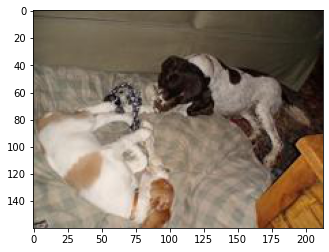

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

shard_filename = 'shards_02/shards-00000.tar'

with tarfile.open(shard_filename, 'r') as tar_file:
    filename = tar_file.next().name
    key = filename.split('.')[0]  # stem
    img_buffer = tar_file.extractfile(key + '.jpg')
    img = np.array(Image.open(img_buffer))
    cls_buffer = tar_file.extractfile(key + '.cls')
    label = int(cls_buffer.read())
plt.imshow(img)
print('label:', label)

## shard作成方法3

次のshard書き出し方法は，いろいろな情報を保存する方法です．サンプルコードの多くは(img, cls)ペアの説明ですが，単にtarに保存するだけなので，様々なものをshard作成時に入れることができます．

In [ ]:
from tqdm.auto import tqdm
from PIL import Image
import io
import json

shard_path = './shards_03'

shard_dir_path = Path(shard_path)
shard_dir_path.mkdir(exist_ok=True)
shard_filename = str(shard_dir_path / 'shards-%05d.tar')
print('shards are saved as', shard_filename)

shard_size = int(50 * 1000**2)  # 50MB each

with wds.ShardWriter(
    shard_filename,
    maxsize=shard_size,
    ) as sink, tqdm(
        file_paths
    ) as pbar:

    for file_path in pbar:

        category_name = file_path.parent.name
        label = category_index[category_name]
        key_str = category_name + '/' + file_path.stem

        with open(file_path, 'rb') as raw_bytes:
            buffer = raw_bytes.read()
        
        img = Image.open(file_path)
        path = Path(file_path)

        info_dic = {
            'label': label,
            'width': img.width,
            'height': img.height,
            'info': img.info,
            'format': img.format,
            'format_description': img.format_description,
            'category name': path.parent.name,
            'ext': path.suffix,
            'file id': path.stem,
            'filesize': path.stat().st_size,  # in bytes
        }

        sink.write({
            "__key__": key_str,
            "jpg": buffer,
            "json": json.dumps(info_dic),
        })

dataset_size = len(shard_filename)

dataset_size_filename = str(
    shard_dir_path / 'dataset-size.json')
with open(dataset_size_filename, 'w') as fp:
    json.dump({
        "dataset size": dataset_size,
        "n_classes": len(category_index),
    }, fp)

shards are saved as shards_03/shards-%05d.tar
# writing shards_03/shards-00000.tar 0 0.0 GB 0


  0%|          | 0/9469 [00:00<?, ?it/s]

# writing shards_03/shards-00001.tar 6050 0.1 GB 6050


In [ ]:
tar_tvf('shards_03/shards-00000.tar')

bigdata/bigdata     6814 n02102040/n02102040_3699.jpg
bigdata/bigdata      281 n02102040/n02102040_3699.json
bigdata/bigdata     9479 n03425413/n03425413_12249.jpg
bigdata/bigdata      282 n03425413/n03425413_12249.json
bigdata/bigdata     7363 n03888257/n03888257_6468.jpg
bigdata/bigdata      281 n03888257/n03888257_6468.json
bigdata/bigdata    10216 n01440764/n01440764_769.jpg
bigdata/bigdata      281 n01440764/n01440764_769.json
bigdata/bigdata     8663 n02979186/n02979186_14197.jpg
bigdata/bigdata      282 n02979186/n02979186_14197.json


{'label': 1, 'width': 213, 'height': 160, 'info': {'jfif': 257, 'jfif_version': [1, 1], 'jfif_unit': 0, 'jfif_density': [1, 1]}, 'format': 'JPEG', 'format_description': 'JPEG (ISO 10918)', 'category name': 'n02102040', 'ext': '.JPEG', 'file id': 'n02102040_3699', 'filesize': 6814}
label: 1


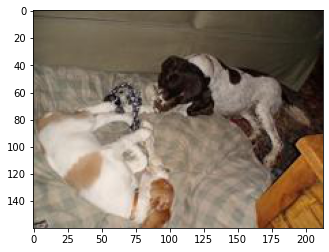

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

shard_filename = 'shards_03/shards-00000.tar'

with tarfile.open(shard_filename, 'r') as tar_file:
    filename = tar_file.next().name
    key = filename.split('.')[0]  # stem
    img_buffer = tar_file.extractfile(key + '.jpg')
    img = np.array(Image.open(img_buffer))
    info_json = tar_file.extractfile(key + '.json')
    info_dic = json.loads(info_json.read())
plt.imshow(img)
print(info_dic)
print('label:', info_dic['label'])

## shard作成方法4

上記の方法はjpeg画像やjsonなど，ファイルにしやすいデータ構造をファイルとして保存していましたが，任意のオブジェクトを保存することもできます．ただしpickleを使うのでpickle化できることが必要ですが．

以下ではいろいろなデータ構造を，一つのpickleファイルとして保存する例です．

In [ ]:
from tqdm.auto import tqdm
from PIL import Image
import io

shard_path = './shards_04'

shard_dir_path = Path(shard_path)
shard_dir_path.mkdir(exist_ok=True)
shard_filename = str(shard_dir_path / 'shards-%05d.tar')
print('shards are saved as', shard_filename)

shard_size = int(50 * 1000**2)  # 50MB each

with wds.ShardWriter(
    shard_filename,
    maxsize=shard_size,
    ) as sink, tqdm(
        file_paths
    ) as pbar:

    for file_path in pbar:

        category_name = file_path.parent.name
        label = category_index[category_name]
        key_str = category_name + '/' + file_path.stem

        with open(file_path, 'rb') as raw_bytes:
            buffer = raw_bytes.read()
        
        img = Image.open(file_path)
        path = Path(file_path)

        info_dic = {
            'label': label,
            'width': img.width,
            'height': img.height,
            'info': img.info,
            'format': img.format,
            'format_description': img.format_description,
            'category name': path.parent.name,
            'ext': path.suffix,
            'file id': path.stem,
            'filesize': path.stat().st_size,  # in bytes
        }

        sink.write({
            "__key__": key_str,
            "pickle": (
                buffer,
                img,
                path,
                info_dic
                )
        })

dataset_size = len(shard_filename)

dataset_size_filename = str(
    shard_dir_path / 'dataset-size.json')
with open(dataset_size_filename, 'w') as fp:
    json.dump({
        "dataset size": dataset_size,
        "n_classes": len(category_index),
    }, fp)

shards are saved as shards_04/shards-%05d.tar
# writing shards_04/shards-00000.tar 0 0.0 GB 0


  0%|          | 0/9469 [00:00<?, ?it/s]

# writing shards_04/shards-00001.tar 441 0.1 GB 441
# writing shards_04/shards-00002.tar 440 0.1 GB 881
# writing shards_04/shards-00003.tar 442 0.1 GB 1323
# writing shards_04/shards-00004.tar 438 0.1 GB 1761
# writing shards_04/shards-00005.tar 449 0.1 GB 2210
# writing shards_04/shards-00006.tar 438 0.1 GB 2648
# writing shards_04/shards-00007.tar 440 0.1 GB 3088
# writing shards_04/shards-00008.tar 442 0.1 GB 3530
# writing shards_04/shards-00009.tar 438 0.1 GB 3968
# writing shards_04/shards-00010.tar 438 0.1 GB 4406
# writing shards_04/shards-00011.tar 447 0.1 GB 4853
# writing shards_04/shards-00012.tar 440 0.1 GB 5293
# writing shards_04/shards-00013.tar 450 0.1 GB 5743
# writing shards_04/shards-00014.tar 446 0.1 GB 6189
# writing shards_04/shards-00015.tar 444 0.1 GB 6633
# writing shards_04/shards-00016.tar 442 0.1 GB 7075
# writing shards_04/shards-00017.tar 445 0.1 GB 7520
# writing shards_04/shards-00018.tar 447 0.1 GB 7967
# writing shards_04/shards-00019.tar 443 0.1 GB 

In [ ]:
tar_tvf('shards_04/shards-00000.tar')

bigdata/bigdata   109563 n02102040/n02102040_3699.pickle
bigdata/bigdata   112230 n03425413/n03425413_12249.pickle
bigdata/bigdata   122112 n03888257/n03888257_6468.pickle
bigdata/bigdata   112963 n01440764/n01440764_769.pickle
bigdata/bigdata   111414 n02979186/n02979186_14197.pickle
bigdata/bigdata   108773 n02102040/n02102040_2493.pickle
bigdata/bigdata   124458 n01440764/n01440764_2144.pickle
bigdata/bigdata   111550 n03425413/n03425413_13973.pickle
bigdata/bigdata   111751 n03028079/n03028079_77417.pickle
bigdata/bigdata   113628 n03394916/n03394916_37186.pickle


<class 'bytes'> <class 'PIL.JpegImagePlugin.JpegImageFile'> <class 'pathlib.PosixPath'> <class 'dict'>
{'label': 1, 'width': 213, 'height': 160, 'info': {'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}, 'format': 'JPEG', 'format_description': 'JPEG (ISO 10918)', 'category name': 'n02102040', 'ext': '.JPEG', 'file id': 'n02102040_3699', 'filesize': 6814}
label 1


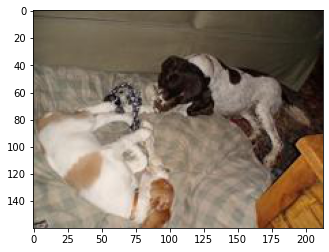

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

shard_filename = 'shards_04/shards-00000.tar'

with tarfile.open(shard_filename, 'r') as tar_file:
    filename = tar_file.next().name
    key = filename.split('.')[0]  # stem
    buffer = tar_file.extractfile(key + '.pickle')
    buffer, img, path, info_dic = pickle.loads(buffer.read())
    print(type(buffer), type(img), type(path), type(info_dic))

plt.imshow(img)
print(info_dic)
print('label', info_dic['label'])

## shard作成方法5

上記の方法は一つのpickleファイルとしていろいろな情報を保存した例ですが，別々のpickleファイルに保存する事もできます．

In [ ]:
from tqdm.auto import tqdm
from PIL import Image
import io

shard_path = './shards_05'

shard_dir_path = Path(shard_path)
shard_dir_path.mkdir(exist_ok=True)
shard_filename = str(shard_dir_path / 'shards-%05d.tar')
print('shards are saved as', shard_filename)

shard_size = int(50 * 1000**2)  # 50MB each

with wds.ShardWriter(
    shard_filename,
    maxsize=shard_size,
    ) as sink, tqdm(
        file_paths
    ) as pbar:

    for file_path in pbar:

        category_name = file_path.parent.name
        label = category_index[category_name]
        key_str = category_name + '/' + file_path.stem

        with open(file_path, 'rb') as raw_bytes:
            buffer = raw_bytes.read()
        
        img = Image.open(file_path)
        path = Path(file_path)

        info_dic = {
            'label': label,
            'width': img.width,
            'height': img.height,
            'info': img.info,
            'format': img.format,
            'format_description': img.format_description,
            'category name': path.parent.name,
            'ext': path.suffix,
            'file id': path.stem,
            'filesize': path.stat().st_size,  # in bytes
        }

        sink.write({
            "__key__": key_str,
            "jpg": buffer,
            "img.pickle": img,
            "path.pickle": path,
            "json": json.dumps(info_dic),
        })

dataset_size = len(shard_filename)

dataset_size_filename = str(
    shard_dir_path / 'dataset-size.json')
with open(dataset_size_filename, 'w') as fp:
    json.dump({
        "dataset size": dataset_size,
        "n_classes": len(category_index),
    }, fp)

shards are saved as shards_05/shards-%05d.tar
# writing shards_05/shards-00000.tar 0 0.0 GB 0


  0%|          | 0/9469 [00:00<?, ?it/s]

# writing shards_05/shards-00001.tar 440 0.1 GB 440
# writing shards_05/shards-00002.tar 440 0.1 GB 880
# writing shards_05/shards-00003.tar 442 0.1 GB 1322
# writing shards_05/shards-00004.tar 438 0.1 GB 1760
# writing shards_05/shards-00005.tar 449 0.1 GB 2209
# writing shards_05/shards-00006.tar 438 0.1 GB 2647
# writing shards_05/shards-00007.tar 440 0.1 GB 3087
# writing shards_05/shards-00008.tar 441 0.1 GB 3528
# writing shards_05/shards-00009.tar 438 0.1 GB 3966
# writing shards_05/shards-00010.tar 438 0.1 GB 4404
# writing shards_05/shards-00011.tar 447 0.1 GB 4851
# writing shards_05/shards-00012.tar 440 0.1 GB 5291
# writing shards_05/shards-00013.tar 449 0.1 GB 5740
# writing shards_05/shards-00014.tar 445 0.1 GB 6185
# writing shards_05/shards-00015.tar 444 0.1 GB 6629
# writing shards_05/shards-00016.tar 442 0.1 GB 7071
# writing shards_05/shards-00017.tar 444 0.1 GB 7515
# writing shards_05/shards-00018.tar 448 0.1 GB 7963
# writing shards_05/shards-00019.tar 443 0.1 GB 

In [ ]:
tar_tvf('shards_05/shards-00000.tar')

bigdata/bigdata   102404 n02102040/n02102040_3699.img.pickle
bigdata/bigdata     6814 n02102040/n02102040_3699.jpg
bigdata/bigdata      281 n02102040/n02102040_3699.json
bigdata/bigdata      107 n02102040/n02102040_3699.path.pickle
bigdata/bigdata   102404 n03425413/n03425413_12249.img.pickle
bigdata/bigdata     9479 n03425413/n03425413_12249.jpg
bigdata/bigdata      282 n03425413/n03425413_12249.json
bigdata/bigdata      108 n03425413/n03425413_12249.path.pickle
bigdata/bigdata   114404 n03888257/n03888257_6468.img.pickle
bigdata/bigdata     7363 n03888257/n03888257_6468.jpg


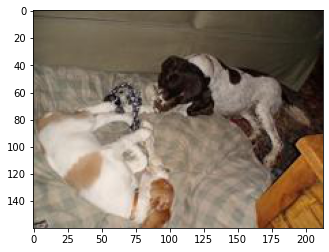

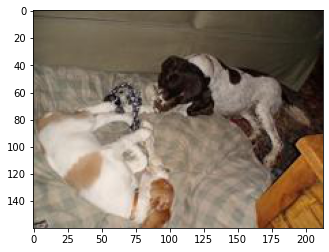

{'label': 1, 'width': 213, 'height': 160, 'info': {'jfif': 257, 'jfif_version': [1, 1], 'jfif_unit': 0, 'jfif_density': [1, 1]}, 'format': 'JPEG', 'format_description': 'JPEG (ISO 10918)', 'category name': 'n02102040', 'ext': '.JPEG', 'file id': 'n02102040_3699', 'filesize': 6814}
label 1


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

shard_filename = 'shards_05/shards-00000.tar'

with tarfile.open(shard_filename, 'r') as tar_file:
    filename = tar_file.next().name
    key = filename.split('.')[0]  # stem
    path = pickle.loads(tar_file.extractfile(key + '.path.pickle').read())
    img_pil = pickle.loads(tar_file.extractfile(key + '.img.pickle').read())
    img = np.array(Image.open(tar_file.extractfile(key + '.jpg')))
    info_dic = json.loads(tar_file.extractfile(key + '.json').read())

plt.imshow(img)
plt.show()
plt.imshow(img_pil)
plt.show()

print(info_dic)
print('label', info_dic['label'])

## shard作成方法6

ではもっと実用的な例を紹介します．semantic segmentation用のcamvidを使って，実画像とラベル画像のペアを1サンプルとして保存して見ます．

In [ ]:
filename = download('https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz')
tar_xzvf(filename)

展開したディレクトリ構造は以下のようになっています．なっています．`images/`と`labels/`に，対応するファイルがペアになって保存されています．

```text:
camvid
├── images
│   ├── 0001TP_006690.png
│   ├── 0001TP_006720.png
│   ...
└── labels 
    ├── 0001TP_006690_P.png
    ├── 0001TP_006720_P.png
    ...
```

ではファイルリストをそれぞれのディレクトリから取得し，ソートします．この場合にはこれで対応が取れます．

In [ ]:
import os

dataset_root_images = './camvid/images/'
dataset_root_labels = './camvid/labels/'

image_paths = sorted([
    path for path in Path(dataset_root_images).glob('*')
    if not path.is_dir() 
        and path.name.endswith((
            '.PNG', '.png',
        ))
])
label_paths = sorted([
    path for path in Path(dataset_root_labels).glob('*')
    if not path.is_dir() 
        and path.name.endswith((
            '.PNG', '.png',
        ))
])

print(image_paths[:2])
print(label_paths[:2])



[PosixPath('camvid/images/0001TP_006690.png'), PosixPath('camvid/images/0001TP_006720.png')]
[PosixPath('camvid/labels/0001TP_006690_P.png'), PosixPath('camvid/labels/0001TP_006720_P.png')]


zipでペアにして，それからシャッフルします．

In [ ]:
path_pair = list(zip(image_paths, label_paths))
random.shuffle(path_pair)
print(path_pair[:2])

[(PosixPath('camvid/images/0006R0_f02070.png'), PosixPath('camvid/labels/0006R0_f02070_P.png')), (PosixPath('camvid/images/0016E5_07050.png'), PosixPath('camvid/labels/0016E5_07050_P.png'))]


ではこれまでと同様にshardに書き込みます．実画像もラベル画像もpngなのですが，実画像はjpegのほうが小さくなるので，jpegでも保存しておきます（この場合には実画像のpngを保存する必要はないのですが，例題としてpngも一緒に保存しています）．

In [ ]:
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
import io

shard_path = './shards_06_camvid'

shard_dir_path = Path(shard_path)
shard_dir_path.mkdir(exist_ok=True)
shard_filename = str(shard_dir_path / 'shards-%05d.tar')
print('shards are saved as', shard_filename)

shard_size = int(150 * 1000**2)  # 150MB each

with wds.ShardWriter(
    shard_filename,
    maxsize=shard_size,
    ) as sink, tqdm(
        path_pair,
        total=len(image_paths)
    ) as pbar:

    for pair in pbar:

        img_path, label_path = pair

        with open(img_path, 'rb') as raw_bytes:
            img_buffer = raw_bytes.read()
        with open(label_path, 'rb') as raw_bytes:
            label_buffer = raw_bytes.read()
        
        sink.write({
            "__key__": img_path.stem,
            "img.png": img_buffer,
            "img.jpg": np.array(Image.open(img_path)),
            "label.png": label_buffer,
            "pair.pickle": (img_buffer, label_buffer)
        })

dataset_size = len(shard_filename)

dataset_size_filename = str(
    shard_dir_path / 'dataset-size.json')
with open(dataset_size_filename, 'w') as fp:
    json.dump({
        "dataset size": dataset_size,
        "n_classes": len(category_index),
    }, fp)

shards are saved as shards_06_camvid/shards-%05d.tar
# writing shards_06_camvid/shards-00000.tar 0 0.0 GB 0


  0%|          | 0/701 [00:00<?, ?it/s]

# writing shards_06_camvid/shards-00001.tar 72 0.2 GB 72
# writing shards_06_camvid/shards-00002.tar 72 0.2 GB 144
# writing shards_06_camvid/shards-00003.tar 72 0.2 GB 216
# writing shards_06_camvid/shards-00004.tar 72 0.2 GB 288
# writing shards_06_camvid/shards-00005.tar 72 0.2 GB 360
# writing shards_06_camvid/shards-00006.tar 71 0.2 GB 431
# writing shards_06_camvid/shards-00007.tar 71 0.2 GB 502
# writing shards_06_camvid/shards-00008.tar 70 0.2 GB 572
# writing shards_06_camvid/shards-00009.tar 72 0.2 GB 644


In [ ]:
tar_tvf('shards_06_camvid/shards-00000.tar')

bigdata/bigdata   457593 0006R0_f02070.img.jpg
bigdata/bigdata   903221 0006R0_f02070.img.png
bigdata/bigdata    28395 0006R0_f02070.label.png
bigdata/bigdata   931636 0006R0_f02070.pair.pickle
bigdata/bigdata   413613 0016E5_07050.img.jpg
bigdata/bigdata   867848 0016E5_07050.img.png
bigdata/bigdata    16780 0016E5_07050.label.png
bigdata/bigdata   884648 0016E5_07050.pair.pickle
bigdata/bigdata   333600 0001TP_009450.img.jpg
bigdata/bigdata   724877 0001TP_009450.img.png


PNG (960, 720)


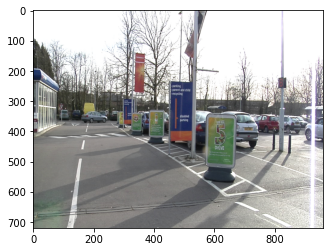

JPEG (960, 720)


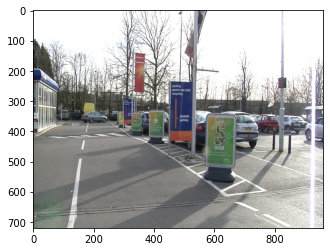

PNG (960, 720)


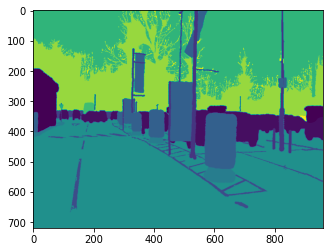

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

shard_filename = 'shards_06_camvid/shards-00000.tar'

with tarfile.open(shard_filename, 'r') as tar_file:
    filename = tar_file.next().name
    key = filename.split('.')[0]  # stem

    img_png = Image.open(tar_file.extractfile(key + '.img.png'))
    img_jpeg = Image.open(tar_file.extractfile(key + '.img.jpg'))
    label = Image.open(tar_file.extractfile(key + '.label.png'))

    plt.imshow(np.array(img_png))
    print(img_png.format, img_png.size)
    plt.show()
    plt.imshow(np.array(img_jpeg))
    print(img_jpeg.format, img_jpeg.size)
    plt.show()
    plt.imshow(np.array(label))
    print(label.format, label.size)
    plt.show()

# webdatasetのshardの読み込み方1

ではshardをwebdatasetのローダーで読み込みます．

## shardの読み込み：よくあるサンプル

まずはシンプルな読み込み方法です．

In [ ]:
import webdataset as wds
from torch.utils.data import DataLoader
import numpy as np

shard_pattern = 'shards_01/shards-{00000..00003}.tar'

dataset = wds.WebDataset(shard_pattern).decode('pil').to_tuple('jpg', 'cls').map_tuple(
        lambda pil_img: np.array(pil_img.resize((224, 224))),
        lambda label: label,
    )
dataloader = DataLoader(
    dataset,
    batch_size=4)

for img, label in dataloader:
    print(img.shape, label)
    break

torch.Size([4, 224, 224, 3]) tensor([1, 7, 9, 0])


`shard_pattern`は特殊な書き方ですが，ローカルファイルではなくweb上のURLでも同じように扱えるようにこの形式（[braceexpand](https://github.com/trendels/braceexpand)）になっています．
以下のように普通のファイルリストも受け付けます．

上記のコードは1行で`dataset`を作っています．このように処理を連結して，処理のパイプラインを作成しています．作成時はまだ処理は行われずにパイプラインが生成されるだけであり，実際にデータを読み込む時点で，パイプラインに設定した各処理が順番に実行されます．

実際に使うことはありませんが，パイプラインの中身である`dataset.pipline`を見ると，順番にリストに処理が追加されている事がわかります．

In [ ]:
print('length of the pipeline: ', len(dataset.pipeline))
print()

for i, p in enumerate(dataset.pipeline):
    print(i, p)

length of the pipeline:  7

0 <webdataset.shardlists.SimpleShardList object at 0x7f1d4d748650>
1 <function single_node_only at 0x7f1d52f2a050>
2 <function split_by_worker at 0x7f1d52f2a0e0>
3 <tarfile_samples () {'handler': <function reraise_exception at 0x7f1d52f8c560>}>
4 <_map (<webdataset.autodecode.Decoder object at 0x7f1d4d748790>,) {'handler': <function reraise_exception at 0x7f1d52f8c560>}>
5 <_to_tuple ('jpg', 'cls') {'handler': <function reraise_exception at 0x7f1d52f8c560>}>
6 <_map_tuple (<function <lambda> at 0x7f1dc09ed050>, <function <lambda> at 0x7f1d4d6dcb00>) {'handler': <function reraise_exception at 0x7f1d52f8c560>}>



### 改行する方法

上記のコードは1行で`dataset`を作っていますが，以下のように書いても同じことです．1行が長くなる場合には，改行するか，`dataset`に代入を繰り返してもよいです．

In [ ]:
import webdataset as wds
from torch.utils.data import DataLoader
import numpy as np

shards_list = [
    'shards_01/shards-00000.tar',
    'shards_01/shards-00001.tar',
    'shards_01/shards-00002.tar',
    'shards_01/shards-00003.tar',
]

dataset = (
    wds.WebDataset(shards_list)
    .decode('pil')
    .to_tuple('jpg', 'cls')
    .map_tuple(
        lambda pil_img: np.array(pil_img.resize((224, 224))),
        lambda label: label,
    ))
dataloader = DataLoader(
    dataset,
    batch_size=4)

for img, label in dataloader:
    print(img.shape, label)
    break

torch.Size([4, 224, 224, 3]) tensor([1, 7, 9, 0])


In [ ]:
import webdataset as wds
from torch.utils.data import DataLoader
import numpy as np
from pathlib import Path

shard_dir = 'shards_01'
shards_list = [
    str(path) for path in Path(shard_dir).glob('*.tar')
    ]

dataset = wds.WebDataset(shards_list)
dataset = dataset.decode('pil')
dataset = dataset.to_tuple('jpg', 'cls')
dataset = dataset.map_tuple(
    lambda pil_img: np.array(pil_img.resize((224, 224))),
    lambda label: label
    )
dataloader = DataLoader(
    dataset,
    batch_size=4)

for img, label in dataloader:
    print(img.shape, label)
    break

torch.Size([4, 224, 224, 3]) tensor([1, 7, 9, 0])


### datasetへ繰り返し代入する方法

以下では`dataset`に代入を繰り返す方法で説明します．そのほうが各ステップで何が起こっているのかがわかりやすいので．

まずは，`dataset`を`Dataloader`で読み込むだけ，他の処理はいっさい省てみます．

In [ ]:
dataset = wds.WebDataset(shards_list)
dataloader = DataLoader(
    dataset,
    batch_size=4)

for sample in dataloader:
    print(type(sample))
    print(sample)
    break

<class 'dict'>
{'__key__': ['n02102040/n02102040_3699', 'n03425413/n03425413_12249', 'n03888257/n03888257_6468', 'n01440764/n01440764_769'], '__url__': ['shards_01/shards-00000.tar', 'shards_01/shards-00000.tar', 'shards_01/shards-00000.tar', 'shards_01/shards-00000.tar'], 'cls': [b'1', b'7', b'9', b'0'], 'jpg': [b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xdb\x00C\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xc0\x00\x11\x08\x00\xa0\x00\xd5\x03\x01"\x00\x02\x11\x01\x03\x11

つまりバッチでdict型が返ってくることがわかりました．

## dataloaderを使わない例

以下では`Dataloader`を使わずに，`dataloader`から直接読み込んでみましょう．


In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

dataset = wds.WebDataset(shards_list)

for sample in dataset:
    print(type(sample))
    sample['jpg'] = sample['jpg'][:30]  # 出力が長いのでこれだけ省略
    pp.pprint(sample)
    break

<class 'dict'>
{   '__key__': 'n02102040/n02102040_3699',
    '__url__': 'shards_01/shards-00000.tar',
    'cls': b'1',
    'jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01'
           b'\x00\x01\x00\x00\xff\xdb\x00C\x00\x01\x01\x01\x01\x01'}


これで1サンプル分のdictの内容がわかりました．

- `__key__`にstemの部分（つまりキー）が入っている
- `__url__`にはtarファイル名が入っている
- `cls`にはバイナリで数値が入っている
- `jpg`にはバイナリでJPEGファイルのバイナリ列が入っている

### PIL.Imageへのデコード

ではデコードしましょう．
`dataset`のパイプラインの途中に
`dataset.decode('pil')`
を入れると，dictのキーとして画像の拡張子（jpeg, jpg, pngなど）が入っていたら，`PIL.Image`型に変換します．

In [ ]:
dataset = wds.WebDataset(shards_list)
dataset = dataset.decode('pil')

for sample in dataset:
    print(type(sample))
    pp.pprint(sample)
    break

<class 'dict'>
{   '__key__': 'n02102040/n02102040_3699',
    '__url__': 'shards_01/shards-00000.tar',
    'cls': 1,
    'jpg': <PIL.Image.Image image mode=RGB size=213x160 at 0x7F1D4D748A90>}


これで，dict型のキー`jpg`の値が`PIL.Image`になりました．

### ndarrayへのデコード

`pil`以外にも，ndarrayやtensorにデコードすることもできます．

In [ ]:
dataset = wds.WebDataset(shards_list)
dataset = dataset.decode('rgb')  # これで(W, H, 3)のndarray

for sample in dataset:
    print(type(sample))
    print(sample['jpg'].shape)
    pp.pprint(sample)
    break

<class 'dict'>
(160, 213, 3)
{   '__key__': 'n02102040/n02102040_3699',
    '__url__': 'shards_01/shards-00000.tar',
    'cls': 1,
    'jpg': array([[[0.31764707, 0.2901961 , 0.22745098],
        [0.32156864, 0.29411766, 0.23137255],
        [0.3254902 , 0.29803923, 0.23529412],
        ...,
        [0.11764706, 0.08627451, 0.07450981],
        [0.1254902 , 0.09411765, 0.08235294],
        [0.13725491, 0.10588235, 0.09411765]],

       [[0.32156864, 0.29411766, 0.23137255],
        [0.32156864, 0.29411766, 0.23137255],
        [0.3254902 , 0.29803923, 0.23529412],
        ...,
        [0.11764706, 0.08627451, 0.07450981],
        [0.11764706, 0.08627451, 0.07450981],
        [0.12941177, 0.09803922, 0.08627451]],

       [[0.3254902 , 0.29803923, 0.23529412],
        [0.32941177, 0.3019608 , 0.23921569],
        [0.3372549 , 0.30980393, 0.24705882],
        ...,
        [0.11764706, 0.08627451, 0.07450981],
        [0.11764706, 0.08627451, 0.07450981],
        [0.11764706, 0.08627451, 

### torch.tensorへのデコード

In [ ]:
dataset = wds.WebDataset(shards_list)
dataset = dataset.decode('torch')  # これで(3, H, W)のtorch.tensorでdtypeはfloat

for sample in dataset:
    print(type(sample))
    print(sample['jpg'].size())
    pp.pprint(sample)
    break

<class 'dict'>
torch.Size([3, 160, 213])
{   '__key__': 'n02102040/n02102040_3699',
    '__url__': 'shards_01/shards-00000.tar',
    'cls': 1,
    'jpg': tensor([[[0.3176, 0.3216, 0.3255,  ..., 0.1176, 0.1255, 0.1373],
         [0.3216, 0.3216, 0.3255,  ..., 0.1176, 0.1176, 0.1294],
         [0.3255, 0.3294, 0.3373,  ..., 0.1176, 0.1176, 0.1176],
         ...,
         [0.3098, 0.2039, 0.2510,  ..., 0.5451, 0.4745, 0.5882],
         [0.4549, 0.4000, 0.4941,  ..., 0.6314, 0.5412, 0.5255],
         [0.4980, 0.3647, 0.4078,  ..., 0.6863, 0.6275, 0.4980]],

        [[0.2902, 0.2941, 0.2980,  ..., 0.0863, 0.0941, 0.1059],
         [0.2941, 0.2941, 0.2980,  ..., 0.0863, 0.0863, 0.0980],
         [0.2980, 0.3020, 0.3098,  ..., 0.0863, 0.0863, 0.0863],
         ...,
         [0.2980, 0.1922, 0.2353,  ..., 0.3412, 0.2706, 0.3843],
         [0.4549, 0.3882, 0.4784,  ..., 0.4275, 0.3373, 0.3216],
         [0.4980, 0.3529, 0.3882,  ..., 0.4824, 0.4235, 0.2941]],

        [[0.2275, 0.2314, 0.2353, 

In [ ]:
dataset = wds.WebDataset(shards_list)
dataset = dataset.decode('torchrgb8')  # これで(3, H, W)のtorch.tensorでdtypeはuint8

for sample in dataset:
    print(type(sample))
    print(sample['jpg'].size())
    pp.pprint(sample)
    break

<class 'dict'>
torch.Size([3, 160, 213])
{   '__key__': 'n02102040/n02102040_3699',
    '__url__': 'shards_01/shards-00000.tar',
    'cls': 1,
    'jpg': tensor([[[ 81,  82,  83,  ...,  30,  32,  35],
         [ 82,  82,  83,  ...,  30,  30,  33],
         [ 83,  84,  86,  ...,  30,  30,  30],
         ...,
         [ 79,  52,  64,  ..., 139, 121, 150],
         [116, 102, 126,  ..., 161, 138, 134],
         [127,  93, 104,  ..., 175, 160, 127]],

        [[ 74,  75,  76,  ...,  22,  24,  27],
         [ 75,  75,  76,  ...,  22,  22,  25],
         [ 76,  77,  79,  ...,  22,  22,  22],
         ...,
         [ 76,  49,  60,  ...,  87,  69,  98],
         [116,  99, 122,  ..., 109,  86,  82],
         [127,  90,  99,  ..., 123, 108,  75]],

        [[ 58,  59,  60,  ...,  19,  21,  24],
         [ 59,  59,  60,  ...,  19,  19,  22],
         [ 60,  61,  63,  ...,  19,  19,  19],
         ...,
         [ 67,  40,  51,  ...,  27,   9,  38],
         [106,  90, 113,  ...,  49,  26,  22],
 

## 自動デコードの種類

画像をデコードできる種類は[コードを見ると](https://github.com/webdataset/webdataset/blob/4dd1f4b47d743e06d6f385343fd4b5a81ecbecde/webdataset/autodecode.py#L154)以下のようになっています．

```python:autodecode.py
imagespecs = {
    "l8": ("numpy", "uint8", "l"),
    "rgb8": ("numpy", "uint8", "rgb"),
    "rgba8": ("numpy", "uint8", "rgba"),
    "l": ("numpy", "float", "l"),
    "rgb": ("numpy", "float", "rgb"),
    "rgba": ("numpy", "float", "rgba"),
    "torchl8": ("torch", "uint8", "l"),
    "torchrgb8": ("torch", "uint8", "rgb"),
    "torchrgba8": ("torch", "uint8", "rgba"),
    "torchl": ("torch", "float", "l"),
    "torchrgb": ("torch", "float", "rgb"),
    "torch": ("torch", "float", "rgb"),
    "torchrgba": ("torch", "float", "rgba"),
    "pill": ("pil", None, "l"),
    "pil": ("pil", None, "rgb"),
    "pilrgb": ("pil", None, "rgb"),
    "pilrgba": ("pil", None, "rgba"),
}
```

上記の例では`cls`キーもバイナリから数値に変換されていました．画像以外のキーは，拡張子に基づいて以下のように自動的にデコードされるようです．

```python:autodecode.py
decoders = {
    "txt": lambda data: data.decode("utf-8"),
    "text": lambda data: data.decode("utf-8"),
    "transcript": lambda data: data.decode("utf-8"),
    "cls": lambda data: int(data),
    "cls2": lambda data: int(data),
    "index": lambda data: int(data),
    "inx": lambda data: int(data),
    "id": lambda data: int(data),
    "json": lambda data: json.loads(data),
    "jsn": lambda data: json.loads(data),
    "pyd": lambda data: pickle.loads(data),
    "pickle": lambda data: pickle.loads(data),
    "pth": lambda data: torch_loads(data),
    "ten": tenbin_loads,
    "tb": tenbin_loads,
    "mp": msgpack_loads,
    "msg": msgpack_loads,
    "npy": npy_loads,
    "npz": lambda data: np.load(io.BytesIO(data)),
    "cbor": cbor_loads,
}
```

一覧にない拡張子の場合には，何もデコードしないようです．

## dictからタプルへの変換

では値をデコードしたdictを，タプルに変換しましょう．（なぜタプルに変換するかというと，webdatasetのサンプルコードでそうなっているため．dictのままでも以後の処理はできます）．

In [ ]:
dataset = wds.WebDataset(shards_list)
dataset = dataset.decode('pil')
dataset = dataset.to_tuple('jpg', 'cls')

for sample in dataset:
    print(type(sample))
    print(sample)
    break

<class 'tuple'>
(<PIL.Image.Image image mode=RGB size=213x160 at 0x7F1DC74C6E90>, 1)


これでタプルになっているのがわかります．
`to_tuple()`で，dictの中から必要なキーを指定して，タプルにします．

`to_tuple()`にはキーのリストを与えてもいいですし，webdatasetのサンプルのように空白で区切った1つの文字列でもよいです．

In [ ]:
dataset = wds.WebDataset(shards_list)
dataset = dataset.decode('pil')
dataset = dataset.to_tuple('jpg cls')

for sample in dataset:
    print(type(sample))
    print(sample)
    break

<class 'tuple'>
(<PIL.Image.Image image mode=RGB size=213x160 at 0x7F1D51F08E10>, 1)


キーには当然`__key__`と`__url__`も使えます．
また同じキーを複数回指定することもできます（何に使うかはともかく）

In [ ]:
dataset = wds.WebDataset(shards_list)
dataset = dataset.decode('pil')
dataset = dataset.to_tuple('cls', '__key__', 'jpg', 'cls')

for sample in dataset:
    print(type(sample))
    print(sample)
    break

<class 'tuple'>
(1, 'n02102040/n02102040_3699', <PIL.Image.Image image mode=RGB size=213x160 at 0x7F1D4D6AE490>, 1)


## mapの適用：map_tuple()

そして，`map_tuple()`で，タプルのそれぞれの要素に適用する関数を指定します．

In [ ]:
dataset = wds.WebDataset(shards_list)
dataset = dataset.decode('pil')
dataset = dataset.to_tuple('jpg', 'cls')
dataset = dataset.map_tuple(
    lambda pil_img: pil_img.resize((224, 224)),
    lambda label: label
    )

for sample in dataset:
    print(type(sample))
    print(sample)
    break

<class 'tuple'>
(<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1D4D6AE1D0>, 1)


上の例では`lambda`関数を与えましたが，当然普通の関数も使えます．

In [ ]:
def resize_img(x):
    return x.resize((224, 224)),

def identity(x):
    return x

dataset = wds.WebDataset(shards_list)
dataset = dataset.decode('pil')
dataset = dataset.to_tuple('jpg', 'cls')
dataset = dataset.map_tuple(resize_img, identity)

for sample in dataset:
    print(type(sample))
    print(sample)
    break

<class 'tuple'>
((<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1D51F08190>,), 1)


### functools.partialを使った例

webdatasetのサンプルコードでは`functools.partial`が使われています．引数をもつ関数を引数に与える場合に便利です．

以下の例はラベルの方にも手を加えてみたものです．

In [ ]:
from functools import partial

def resize_img(x, shape):
    return x.resize(shape),

def label_transform(x):
    return 'label:' + str(x)

resize_func = partial(
    resize_img,
    shape=(224, 224))

dataset = wds.WebDataset(shards_list)
dataset = dataset.decode('pil')
dataset = dataset.to_tuple('jpg', 'cls')
dataset = dataset.map_tuple(resize_func, label_transform)

for sample in dataset:
    print(type(sample))
    print(sample)
    break


<class 'tuple'>
((<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1D4D6D0790>,), 'label:1')


### map_dict()の使用例

ドキュメントにはつかい方がのっていませんが，[コードを見ると](https://github.com/webdataset/webdataset/blob/05a1ea1116781ffe3c3bc257061f2f3e51dfeb0b/webdataset/tests/test_xcompat.py#L254)タプルにせずともdictにそのまま`map`を適用する`map_dict`が以下のように使えます．




In [ ]:
from functools import partial

def resize_img(x, shape):
    return x.resize(shape),

def label_transform(x):
    return 'label:' + str(x)

resize_func = partial(
    resize_img,
    shape=(224, 224))

dataset = wds.WebDataset(shards_list)
dataset = dataset.decode('pil')
dataset = dataset.map_dict(
    jpg=resize_func,
    cls=label_transform
    )

for sample in dataset:
    print(type(sample))
    pp.pprint(sample)
    break


<class 'dict'>
{   '__key__': 'n02102040/n02102040_3699',
    '__url__': 'shards_01/shards-00000.tar',
    'cls': 'label:1',
    'jpg': (<PIL.Image.Image image mode=RGB size=224x224 at 0x7F1D521A5E50>,)}


dictのまま扱うことになにかメリットがあれば有用でしょう．通常は`to_tuple`で必要なキーだけを抜き出してタプルにすればよいです．

## 自作デコーダの作成

### デコーダで処理

キーが画像の拡張子やデフォルトで受け付けるもの以外をデコードしたい場合には，自分でデコーダを作成します．そのためには，`decode()`に`wds.handle_extension`で自作関数を以下のように与えます．

In [ ]:
from PIL import Image
import io
import numpy as np

def my_jpg_decoder(x):
    img = Image.open(io.BytesIO(x))
    img = img.resize((224, 224))
    return img

def my_label_decoder(x):
    return 'label decode: ' + str(int(x))  # byte->int->str

dataset = wds.WebDataset(shards_list)
dataset = dataset.decode(
    wds.handle_extension('jpg', my_jpg_decoder),
    wds.handle_extension('cls', my_label_decoder),
    )


for sample in dataset:
    print(type(sample))
    pp.pprint(sample)
    break


<class 'dict'>
{   '__key__': 'n02102040/n02102040_3699',
    '__url__': 'shards_01/shards-00000.tar',
    'cls': 'label decode: 1',
    'jpg': <PIL.Image.Image image mode=RGB size=224x224 at 0x7F1D52ADAD90>}


### デコーダとmapで処理

ではデコードとmapを両方使ってみましょう．

以下は自作デコーダで画像を`PIL.Image`にして，mapのほうでリサイズしてndarrayに変換しています．

In [ ]:
from PIL import Image
import io
import numpy as np

def my_jpg_decoder(x):
    img = Image.open(io.BytesIO(x))
    return img

def my_label_decoder(x):
    return 'label decode: ' + str(int(x))

def resize_img(x):
    return np.array(x.resize((224, 224)))

def label_transform(x):
    return 'label transform: ' + str(x)

dataset = wds.WebDataset(shards_list)
dataset = dataset.decode(
    wds.handle_extension('jpg', my_jpg_decoder),
    wds.handle_extension('cls', my_label_decoder),
    )
dataset = dataset.to_tuple('jpg', 'cls')
dataset = dataset.map_tuple(resize_img, label_transform)


for sample in dataset:
    print(type(sample))
    print('shape: ', sample[0].shape)
    print('max: ', sample[0].max())
    print(sample[1])
    break


<class 'tuple'>
shape:  (224, 224, 3)
max:  253
label transform: label decode: 1


### transformの適用

ではもっと実践的な例として，torch.tensorにtransformを適用するという，よくある例を考えてみます．

上記までの例で分かるように，shardから取り出したbyteデータを処理するには，decodeとmapの2箇所があることがわかります．どこで何を処理するのかは設計次第です（decodeでデコードとtransformまでやってしまっても良いし，decodeではデコードだけしてmapでtransformを適用する，など）．


In [ ]:
from torchvision.io import decode_jpeg
from torchvision import transforms
from torchvision.transforms import (
    RandomResizedCrop,
    Normalize,
    RandomHorizontalFlip,
    Compose,
)
from torch import frombuffer
import torch
from functools import partial


def get_transform():
    transform_list = [
        RandomResizedCrop(224),
        RandomHorizontalFlip(),
        transforms.Lambda(lambda x: x / 255.),
        Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]),      
    ]

    transform = Compose(transform_list)
    return transform

def my_decoder(x, device):
    x = decode_jpeg(
        frombuffer(x, dtype=torch.uint8),
        device=device)
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

decoder_func = partial(
    my_decoder,
    device=device
)

def transform_img(x, transform):
    return transform(x)

transform_func = partial(
    transform_img,
    transform=get_transform()
)

def identity(x):
    return x

dataset = wds.WebDataset(shards_list)
dataset = dataset.decode(
    wds.handle_extension('jpg', decoder_func),
    )
dataset = dataset.to_tuple('jpg', 'cls')
dataset = dataset.map_tuple(transform_func, identity, identity)


for sample in dataset:
    print(type(sample))
    print(type(sample[0]))
    print('shape: ', sample[0].shape)
    print('device: ', sample[0].device)
    print('max: ', sample[0].max())
    print(sample[1])
    break


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:1105.)


<class 'tuple'>
<class 'torch.Tensor'>
shape:  torch.Size([3, 224, 224])
device:  cuda:0
max:  tensor(1.4098, device='cuda:0')
1


上記のコードの説明です．

- デコーダではbyte型の`x`を`frombuffer`でtorch.tensorにしてから，torchvisionの`decode_jpeg`を使っています（同時にdeviceに送っています）．
- mapではtransformを適用しています．すでにtensor型なので，よくある`ToTensor`は不要で，255で割る処理だけが必要です．

## dataloaderでバッチ取得

ではようやく`Dalaloader`を使ってバッチを取得するところまで来ました．webdatasetオブジェクトの作成は全部一つの関数の中に入れ込んでしまいましょう

In [ ]:
from torchvision.io import decode_jpeg
from torchvision import transforms
from torchvision.transforms import (
    RandomResizedCrop,
    Normalize,
    RandomHorizontalFlip,
    Compose,
)
from torch import frombuffer
import torch
from functools import partial
from torch.utils.data import DataLoader


def get_dataset(shard_dir, device):

    def info_from_json(shard_dir):
        with open(Path(shard_dir) / 'dataset-size.json', 'r') as f:
            info_dic = json.load(f)
        return info_dic['dataset size']

    shards_list = [
        str(path) for path in Path(shard_dir).glob('*.tar')
        ]

    def get_transform():
        transform_list = [
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            transforms.Lambda(lambda x: x / 255.),
            Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),      
        ]

        transform = Compose(transform_list)
        return transform

    def my_decoder(x, device):
        x = decode_jpeg(
            frombuffer(x, dtype=torch.uint8),
            device=device)
        return x

    decoder_func = partial(
        my_decoder,
        device=device
    )

    def transform_img(x, transform):
        return transform(x)

    transform_func = partial(
        transform_img,
        transform=get_transform()
    )

    def identity(x):
        return x

    dataset = wds.WebDataset(shards_list)
    dataset = dataset.decode(
        wds.handle_extension('jpg', decoder_func),
        )
    dataset = dataset.to_tuple('jpg', 'cls')
    dataset = dataset.map_tuple(transform_func, identity)

    dataset_size = info_from_json(shard_dir)
    dataset = dataset.with_length(dataset_size)
    
    return dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_01',
        device=device),
    batch_size=4)

for sample in dataloader:
    print(type(sample))
    print(type(sample[0]))
    print('shape: ', sample[0].shape)
    print('device: ', sample[0].device)
    print('max: ', sample[0].max())
    print(sample[1])
    break


<class 'list'>
<class 'torch.Tensor'>
shape:  torch.Size([4, 3, 224, 224])
device:  cuda:0
max:  tensor(2.6226, device='cuda:0')
tensor([1, 7, 9, 0])


なお，これまでは`dataset`データセットサイズを指定していませんでした．shardファイル作成時にjsonファイルにサイズを保存しておいたので，上記のコードではそれを読み込んでいます．データセットのサイズを設定するために，パイプラインの最後で`dataset.with_length(dataset_size)`で設定しています．


# wabdatasetのshardの読み込み方2

`shard_dir`を変えてもshardの中身が同じなら，変更なしで動きます．

In [ ]:
dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_02',
        device=device),
    batch_size=4)

for sample in dataloader:
    print(type(sample))
    print(type(sample[0]))
    print('shape: ', sample[0].shape)
    print('device: ', sample[0].device)
    print('max: ', sample[0].max())
    print(sample[1])
    break

<class 'list'>
<class 'torch.Tensor'>
shape:  torch.Size([4, 3, 224, 224])
device:  cuda:0
max:  tensor(2.6400, device='cuda:0')
tensor([1, 7, 9, 0])


# wabdatasetのshardの読み込み方3

ではshard構造が異なるものを扱ってみましょう．
データが`cls`キーではなく`json`になっている場合には，自動的にdictにデコードされます．したがって変更は，`to_tuple`で`cls`から`json`にするだけです．

In [ ]:
from torchvision.io import decode_jpeg
from torchvision import transforms
from torchvision.transforms import (
    RandomResizedCrop,
    Normalize,
    RandomHorizontalFlip,
    Compose,
)
from torch import frombuffer
import torch
from functools import partial
from torch.utils.data import DataLoader
import json


def get_dataset(shard_dir, device):

    def info_from_json(shard_dir):
        with open(Path(shard_dir) / 'dataset-size.json', 'r') as f:
            info_dic = json.load(f)
        return info_dic['dataset size']

    shards_list = [
        str(path) for path in Path(shard_dir).glob('*.tar')
        ]

    def get_transform():
        transform_list = [
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            transforms.Lambda(lambda x: x / 255.),
            Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),      
        ]

        transform = Compose(transform_list)
        return transform

    def my_decoder(x, device):
        x = decode_jpeg(
            frombuffer(x, dtype=torch.uint8),
            device=device)
        return x

    decoder_func = partial(
        my_decoder,
        device=device
    )

    def transform_img(x, transform):
        return transform(x)

    transform_func = partial(
        transform_img,
        transform=get_transform()
    )

    def identity(x):
        return x

    dataset = wds.WebDataset(shards_list)
    dataset = dataset.decode(
        wds.handle_extension('jpg', decoder_func),
        )
    dataset = dataset.to_tuple('jpg', 'json')
    dataset = dataset.map_tuple(transform_func, identity)

    dataset_size = info_from_json(shard_dir)
    dataset = dataset.with_length(dataset_size)
    
    return dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_03',
        device=device),
    batch_size=4)

for sample in dataloader:
    print(type(sample))
    print(type(sample[0]))
    print('shape: ', sample[0].shape)
    print('device: ', sample[0].device)
    print(sample[1])
    print('max: ', sample[0].max())
    print('label: ', sample[1]['label'])
    break


<class 'list'>
<class 'torch.Tensor'>
shape:  torch.Size([4, 3, 224, 224])
device:  cuda:0
{'label': tensor([1, 7, 9, 0]), 'width': tensor([213, 213, 238, 213]), 'height': tensor([160, 160, 160, 160]), 'info': {'jfif': tensor([257, 257, 257, 257]), 'jfif_version': [tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1])], 'jfif_unit': tensor([0, 0, 0, 0]), 'jfif_density': [tensor([1, 1, 1, 1]), tensor([1, 1, 1, 1])]}, 'format': ['JPEG', 'JPEG', 'JPEG', 'JPEG'], 'format_description': ['JPEG (ISO 10918)', 'JPEG (ISO 10918)', 'JPEG (ISO 10918)', 'JPEG (ISO 10918)'], 'category name': ['n02102040', 'n03425413', 'n03888257', 'n01440764'], 'ext': ['.JPEG', '.JPEG', '.JPEG', '.JPEG'], 'file id': ['n02102040_3699', 'n03425413_12249', 'n03888257_6468', 'n01440764_769'], 'filesize': tensor([ 6814,  9479,  7363, 10216])}
max:  tensor(2.1520, device='cuda:0')
label:  tensor([1, 7, 9, 0])


# wabdatasetのshardの読み込み方4


データが`pickle`キーだけの場合には，デコードは自動処理にまかせて（`decode()`には引数がないですが自動デコードできるものはします），自分でmapで処理します．

In [ ]:
from torchvision.io import decode_jpeg
from torchvision import transforms
from torchvision.transforms import (
    RandomResizedCrop,
    Normalize,
    RandomHorizontalFlip,
    Compose,
)
from torch import frombuffer
import torch
from functools import partial
from torch.utils.data import DataLoader
import json


def get_dataset(shard_dir, device):

    def info_from_json(shard_dir):
        with open(Path(shard_dir) / 'dataset-size.json', 'r') as f:
            info_dic = json.load(f)
        return info_dic['dataset size']

    shards_list = [
        str(path) for path in Path(shard_dir).glob('*.tar')
        ]

    def get_transform():
        transform_list = [
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            transforms.Lambda(lambda x: x / 255.),
            Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),      
        ]

        transform = Compose(transform_list)
        return transform

    def transform_pickle(x, transform, device):
        buffer, pil_img, path, info_dic = x

        tensor_img = decode_jpeg(
            frombuffer(buffer, dtype=torch.uint8),
            device=device)
        tensor_img = transform(tensor_img)

        label = info_dic['label']

        return tensor_img, label

    transform_func = partial(
        transform_pickle,
        transform=get_transform(),
        device=device
    )

    dataset = wds.WebDataset(shards_list)
    dataset = dataset.decode()
    dataset = dataset.to_tuple('pickle')
    dataset = dataset.map_tuple(transform_func)

    dataset_size = info_from_json(shard_dir)
    dataset = dataset.with_length(dataset_size)
    
    return dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_04',
        device=device),
    batch_size=4)

for sample_list in dataloader:
    sample = sample_list[0]
    print(type(sample))
    print(type(sample[0]))
    print('shape: ', sample[0].shape)
    print('device: ', sample[0].device)
    print('max: ', sample[0].max())
    print(sample[1])
    break


<class 'list'>
<class 'torch.Tensor'>
shape:  torch.Size([4, 3, 224, 224])
device:  cuda:0
max:  tensor(2.6400, device='cuda:0')
tensor([2, 4, 8, 2])


ちなみにキーが`pickle`一つだけが理由なのか，collateがうまく処理されません．そこで，dataloaderで出てくる要素の0を取り出すアドホックな処理を入れています．

もっときれいにやるなら，自作のcollate関数を作って以下のようにすればOKです（どのようなcollate関数を作るのかはいろいろ試すしかない．．．）

In [ ]:
from torchvision.io import decode_jpeg
from torchvision import transforms
from torchvision.transforms import (
    RandomResizedCrop,
    Normalize,
    RandomHorizontalFlip,
    Compose,
)
from torch import frombuffer
import torch
from functools import partial
from torch.utils.data import DataLoader
import json


def get_dataset(shard_dir, device):

    shards_list = [
        str(path) for path in Path(shard_dir).glob('*.tar')
        ]

    def get_transform():
        transform_list = [
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            transforms.Lambda(lambda x: x / 255.),
            Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),      
        ]

        transform = Compose(transform_list)
        return transform

    def transform_pickle(x, transform, device):
        buffer, pil_img, path, info_dic = x

        tensor_img = decode_jpeg(
            frombuffer(buffer, dtype=torch.uint8),
            device=device)
        tensor_img = transform(tensor_img)

        label = info_dic['label']

        return tensor_img, label

    transform_func = partial(
        transform_pickle,
        transform=get_transform(),
        device=device
    )

    dataset = wds.WebDataset(shards_list)
    dataset = dataset.decode()
    dataset = dataset.to_tuple('pickle')
    dataset = dataset.map_tuple(transform_func)

    return dataset

def my_collate(batch):
    return torch.utils.data.default_collate([b[0] for b in batch])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_04',
        device=device),
    batch_size=4,
    collate_fn=my_collate)

for sample in dataloader:
    print(type(sample))
    print(type(sample[0]))
    print('shape: ', sample[0].shape)
    print('device: ', sample[0].device)
    print('max: ', sample[0].max())
    print(sample[1])
    break


<class 'list'>
<class 'torch.Tensor'>
shape:  torch.Size([4, 3, 224, 224])
device:  cuda:0
max:  tensor(2.6400, device='cuda:0')
tensor([2, 4, 8, 2])


# wabdatasetのshardの読み込み方5

複数の`pickle`キーから画像をデコードする例です．

shard作成時には以下のようにしています．

```python:
    sink.write({
        "__key__": key_str,
        "jpg": buffer,
        "img.pickle": img,
        "path.pickle": path,
        "json": json.dumps(info_dic),
    })
```

以下は`jpg`キーのbufferからデコードして，jsonからラベルを取り出すだけの処理です．

In [ ]:
from torchvision.io import decode_jpeg
from torchvision import transforms
from torchvision.transforms import (
    RandomResizedCrop,
    Normalize,
    RandomHorizontalFlip,
    Compose,
)
from torch import frombuffer
import torch
from functools import partial
from torch.utils.data import DataLoader
import json


def get_dataset(shard_dir, device):

    def info_from_json(shard_dir):
        with open(Path(shard_dir) / 'dataset-size.json', 'r') as f:
            info_dic = json.load(f)
        return info_dic['dataset size']

    shards_list = [
        str(path) for path in Path(shard_dir).glob('*.tar')
        ]

    def get_transform():
        transform_list = [
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            transforms.Lambda(lambda x: x / 255.),
            Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),      
        ]

        transform = Compose(transform_list)
        return transform

    def my_decoder(x, device):
        x = decode_jpeg(
            frombuffer(x, dtype=torch.uint8),
            device=device)
        return x

    decoder_func = partial(
        my_decoder,
        device=device
    )

    def transform_img(x, transform):
        return transform(x)

    transform_func = partial(
        transform_img,
        transform=get_transform()
    )

    dataset = wds.WebDataset(shards_list)
    dataset = dataset.decode(
        wds.handle_extension('jpg', decoder_func),
        )
    dataset = dataset.to_tuple('jpg', 'json')
    dataset = dataset.map_tuple(
        transform_func,
        lambda x: x['label']
        )

    dataset_size = info_from_json(shard_dir)
    dataset = dataset.with_length(dataset_size)
    
    return dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_05',
        device=device),
    batch_size=4)

for sample in dataloader:
    print(type(sample))
    print(type(sample[0]))
    print('shape: ', sample[0].shape)
    print('device: ', sample[0].device)
    print('max: ', sample[0].max())
    print(sample[1])
    break


<class 'list'>
<class 'torch.Tensor'>
shape:  torch.Size([4, 3, 224, 224])
device:  cuda:0
max:  tensor(2.6400, device='cuda:0')
tensor([4, 2, 4, 8])


`jpg`キーの画像のデコードをおまかせするなら以下のようになります．デコードに`torch`を指定してtensorにすればOKです．ただしこのデコードでfloat32になるので，255で割る処理は不要です．

In [ ]:
from torchvision.io import decode_jpeg
from torchvision import transforms
from torchvision.transforms import (
    RandomResizedCrop,
    Normalize,
    RandomHorizontalFlip,
    Compose,
)
from torch import frombuffer
import torch
from functools import partial
from torch.utils.data import DataLoader
import json


def get_dataset(shard_dir, device):

    shards_list = [
        str(path) for path in Path(shard_dir).glob('*.tar')
        ]

    def get_transform():
        transform_list = [
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            # transforms.Lambda(lambda x: x / 255.),
            Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),      
        ]

        transform = Compose(transform_list)
        return transform

    def transform_img(x, transform):
        return transform(x)

    transform_func = partial(
        transform_img,
        transform=get_transform()
    )
    
    dataset = wds.WebDataset(shards_list)
    dataset = dataset.decode('torch')
    dataset = dataset.to_tuple('jpg', 'json')
    dataset = dataset.map_tuple(
        transform_func,
        lambda x: x['label']
        )

    return dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_05',
        device=device),
    batch_size=4)

for sample in dataloader:
    print(type(sample))
    print(type(sample[0]))
    print('shape: ', sample[0].shape)
    print('device: ', sample[0].device)
    print('max: ', sample[0].max())
    print(sample[1])
    break


<class 'list'>
<class 'torch.Tensor'>
shape:  torch.Size([4, 3, 224, 224])
device:  cpu
max:  tensor(2.6400)
tensor([4, 2, 4, 8])


# wabdatasetのshardの読み込み方6

ではcamvidのセマンティックセグメンテーション用のデータを固めたshardを読み込んでみましょう．

作成時のshardの構造は以下の通り．

```python:
sink.write({
    "__key__": img_path.stem,
    "img.png": img_buffer,
    "img.jpg": np.array(Image.open(img_path)),
    "label.png": label_buffer,
    "pair.pickle": (img_buffer, label_buffer)
})
```

ここから`img.png`と`label.png`の2枚の画像を読み込みます．
ラベル画像は整数値なので，デコード指定にはrgbのuint8を指定し，transformで255で割るかどうかを切り替えます．

<class 'list'>
<class 'torch.Tensor'>
shape:  torch.Size([4, 3, 224, 224])
dtype:  torch.float32
device:  cpu
to.device:  cuda:0
max:  tensor(2.6400)
<class 'torch.Tensor'>
shape:  torch.Size([4, 3, 224, 224])
dtype:  torch.float32
device:  cpu
to.device:  cuda:0
max:  tensor(31.)


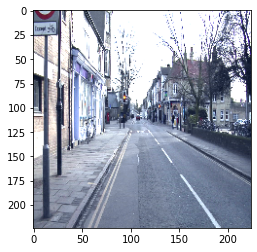

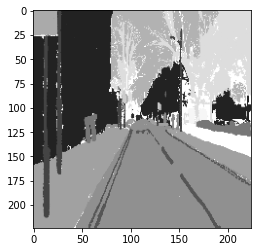

In [ ]:
from torchvision.io import decode_jpeg
from torchvision import transforms
from torchvision.transforms import (
    Resize,
    Normalize,
    RandomHorizontalFlip,
    Compose,
)
import torch
from functools import partial
from torch.utils.data import DataLoader


def get_dataset(shard_dir, device):

    def info_from_json(shard_dir):
        with open(Path(shard_dir) / 'dataset-size.json', 'r') as f:
            info_dic = json.load(f)
        return info_dic['dataset size']
        
    shards_list = [
        str(path) for path in Path(shard_dir).glob('*.tar')
        ]

    def get_transform(is_label=False):
        transform_list = [
            Resize((224, 224)),
        ]
        if not is_label:
            transform_list.extend([
                transforms.Lambda(lambda x: x / 255.),
                Normalize(
                    [0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225]),      
            ])
        else:
            transform_list.append(
                transforms.Lambda(lambda x: x.to(torch.float)))

        transform = Compose(transform_list)
        return transform

    def transform_img(x, transform):
        return transform(x)
    
    dataset = wds.WebDataset(shards_list)
    dataset = dataset.decode('torchrgb8')
    dataset = dataset.to_tuple('img.png', 'label.png')
    dataset = dataset.map_tuple(
        partial(transform_img,
                transform=get_transform(is_label=False)),
        partial(transform_img,
                transform=get_transform(is_label=True)),
        )
    
    dataset_size = info_from_json(shard_dir)
    dataset = dataset.with_length(dataset_size)

    return dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_06_camvid',
        device=device),
    batch_size=4)

for sample in dataloader:
    print(type(sample))

    print(type(sample[0]))
    print('shape: ', sample[0].shape)
    print('dtype: ', sample[0].dtype)
    print('device: ', sample[0].device)
    print('to.device: ', sample[0].to(device).device)
    print('max: ', sample[0].max())

    print(type(sample[1]))
    print('shape: ', sample[1].shape)
    print('dtype: ', sample[1].dtype)
    print('device: ', sample[1].device)
    print('to.device: ', sample[1].to(device).device)
    print('max: ', sample[1].max())

    break


img = sample[0][0].detach().cpu().permute(1,2,0).numpy()
plt.imshow((img - img.min()) / img.max())
plt.show()

label = sample[1][0].detach().cpu().permute(1,2,0).numpy() / 30
plt.imshow(label)
plt.show()

しかし上のようなやり方では，imageとlabelに同じ幾何変換を適用することができません．セグメンテーション用のデータ拡張のときに，単純にランダムにresizeやcropや反転を行うと，imageとlabelで別々の画像処理が行われてしまします．

そこで[albumentations](https://albumentations.ai/docs/getting_started/mask_augmentation/)を使います．このalbumentationsのtransformを使うと，imageとlabelの画像に同じ変換を適用することができます．さらにNormalizeやFloat変換などはlabelには適用されないので便利です．

そのためには，「`img.png`と`label.png`という2つのキーから別々に2枚の画像を読み込む」というやり方を変更します．webdatasetのパイプラインでは，別々のキーから読み込んだデータはいつまでも別々のままで一つにすることができません．そのため，以下のようにpickleでimgとlabelを一つにまとめたキー`pair.pickle`から読み込むことにします．

またabumentationsはndarrayしか扱えないようなので，デーコーダでは`np.array`を使います．

<class 'list'>
<class 'torch.Tensor'>
shape:  torch.Size([4, 3, 224, 224])
dtype:  torch.float32
device:  cuda:0
to.device:  cuda:0
max:  tensor(2.6400, device='cuda:0')
<class 'torch.Tensor'>
shape:  torch.Size([4, 3, 224, 224])
dtype:  torch.float32
device:  cuda:0
to.device:  cuda:0
max:  tensor(31., device='cuda:0')


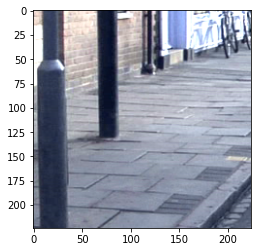

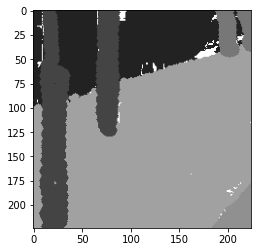

In [ ]:
from torchvision.io import decode_jpeg
from torchvision import transforms
from torchvision.transforms import (
    Resize,
    Normalize,
    RandomHorizontalFlip,
    Compose,
)
import torch
from functools import partial
from torch.utils.data import DataLoader
import numpy as np
import albumentations as A
import albumentations.pytorch as Ap


def get_dataset(shard_dir, device):

    shards_list = [
        str(path) for path in Path(shard_dir).glob('*.tar')
        ]

    def get_transform():
        transform_list = [
            A.RandomResizedCrop(224, 224),
            A.Normalize(
                [0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),
            Ap.ToTensorV2(),  # HWC --> CHW
        ]

        transform = A.Compose(transform_list)
        return transform

    def decode_png(buf):
        return np.array(Image.open(io.BytesIO(buf)).convert('RGB'))

    def transform_pair(x, transform, device):
        img, label = x
        img = decode_png(img)
        label = decode_png(label)

        transformed = transform(image=img, mask=label)
        
        img = torch.as_tensor(
            transformed['image'], 
            device=device)
        label = torch.as_tensor(
            transformed['mask'], 
            device=device)

        return (
            img,  # CHW,float32
            label.permute(2,0,1).to(torch.float)  # HWC,uint8 --> CHW,float32
            )


    transform_func = partial(
        transform_pair,
        transform=get_transform(),
        device=device
    )

    dataset = wds.WebDataset(shards_list)
    dataset = dataset.decode()
    dataset = dataset.to_tuple('pair.pickle')
    dataset = dataset.map_tuple(transform_func)

    return dataset


def my_collate(batch):
    return torch.utils.data.default_collate([b[0] for b in batch])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_06_camvid',
        device=device),
    batch_size=4,
    collate_fn=my_collate)

for sample in dataloader:
    print(type(sample))

    print(type(sample[0]))
    print('shape: ', sample[0].shape)
    print('dtype: ', sample[0].dtype)
    print('device: ', sample[0].device)
    print('to.device: ', sample[0].to(device).device)
    print('max: ', sample[0].max())

    print(type(sample[1]))
    print('shape: ', sample[1].shape)
    print('dtype: ', sample[1].dtype)
    print('device: ', sample[1].device)
    print('to.device: ', sample[1].to(device).device)
    print('max: ', sample[1].max())

    break


img = sample[0][0].detach().cpu().permute(1,2,0).numpy()
plt.imshow((img - img.min()) / img.max())
plt.show()

label = sample[1][0].detach().cpu().permute(1,2,0).numpy() / 30
plt.imshow(label)
plt.show()

# シャッフルの方法

webdatasetは複数のshard（tarファイル）の中から順番にデータを取り出します．そのため，学習に用いるサンプルの順番が毎回（エポックごとに）同じになります．もしshard生成時に，クラス順にデータをtarに固めてしまうと，shardから取り出したサンプルは同じクラスのものが連続してしまうことになります．通常これは学習にとって悪影響を与えます（ランダムにサンプルをとってきて学習に使わなければ，性能が落ちます）．

そのためwebdatasetではパイプラインの途中にシャッフルする仕組みがあります．



## テスト用のshard作成

その仕組によるシャッフルの様子を見るために，まずは以下のようなテスト用shardを作ります．
tarファイルの中には，shard番号と，そのtarファイル中のサンプルの番号をもつjsonを作ります．

In [ ]:
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
import json
from pathlib import Path

shard_path = './shards_07_test'

shard_dir_path = Path(shard_path)
shard_dir_path.mkdir(exist_ok=True)
shard_filename = str(shard_dir_path / 'shards-%05d.tar')

n_samples = 57
max_count = 11
max_size = 1000**2

with wds.ShardWriter(
    shard_filename,
    maxsize=max_size,
    maxcount=max_count,
    ) as sink, tqdm(
        range(n_samples)
    ) as pbar:

    print(sink.maxcount)

    for i in pbar:

        if sink.count >= sink.maxcount:
            shard = sink.shard + 1
            count = 0
        else:
            shard = sink.shard  # 1-origin
            count = sink.count  # 0-origin

        sample_dic ={
            '__key__': str(i),
            'json': json.dumps({
                'shard': shard - 1,  # 0-origin
                'sample': count
            })
        }
        sink.write(sample_dic)
        print(sample_dic)

    dataset_size = sink.total


dataset_size_filename = str(
    shard_dir_path / 'dataset-size.json')
with open(dataset_size_filename, 'w') as fp:
    json.dump({
        "dataset size": dataset_size,
    }, fp)

# writing shards_07_test/shards-00000.tar 0 0.0 GB 0


  0%|          | 0/57 [00:00<?, ?it/s]

11
{'__key__': '0', 'json': '{"shard": 0, "sample": 0}'}
{'__key__': '1', 'json': '{"shard": 0, "sample": 1}'}
{'__key__': '2', 'json': '{"shard": 0, "sample": 2}'}
{'__key__': '3', 'json': '{"shard": 0, "sample": 3}'}
{'__key__': '4', 'json': '{"shard": 0, "sample": 4}'}
{'__key__': '5', 'json': '{"shard": 0, "sample": 5}'}
{'__key__': '6', 'json': '{"shard": 0, "sample": 6}'}
{'__key__': '7', 'json': '{"shard": 0, "sample": 7}'}
{'__key__': '8', 'json': '{"shard": 0, "sample": 8}'}
{'__key__': '9', 'json': '{"shard": 0, "sample": 9}'}
{'__key__': '10', 'json': '{"shard": 0, "sample": 10}'}
# writing shards_07_test/shards-00001.tar 11 0.0 GB 11
{'__key__': '11', 'json': '{"shard": 1, "sample": 0}'}
{'__key__': '12', 'json': '{"shard": 1, "sample": 1}'}
{'__key__': '13', 'json': '{"shard": 1, "sample": 2}'}
{'__key__': '14', 'json': '{"shard": 1, "sample": 3}'}
{'__key__': '15', 'json': '{"shard": 1, "sample": 4}'}
{'__key__': '16', 'json': '{"shard": 1, "sample": 5}'}
{'__key__': '17'

## シャッフルなしのshardよみこみ

ではこのshardファイルを読み込んでみます．

まずはシャッフルなしの場合．シャッフルの効果を見るために，shardファイルのリストをsortしておきます．

In [ ]:
import torch
from functools import partial
from torch.utils.data import DataLoader
from pathlib import Path


def get_dataset(shard_dir):

    def info_from_json(shard_dir):
        with open(Path(shard_dir) / 'dataset-size.json', 'r') as f:
            info_dic = json.load(f)
        return info_dic['dataset size']

    shards_list = sorted([
        str(path) for path in Path(shard_dir).glob('*.tar')
        ])

    dataset = wds.WebDataset(shards_list)
    dataset = dataset.decode()
    dataset = dataset.to_tuple('json')
    dataset = dataset.map_tuple(
        lambda x: x
    )

    dataset_size = info_from_json(shard_dir)
    dataset = dataset.with_length(dataset_size)

    return dataset


dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_07_test',
        ),
    batch_size=5)


n_epochs = 2
for epoch in range(n_epochs):
    for sample in dataloader:
        print(f'Epoch {epoch}: ', sample)


Epoch 0:  [{'shard': tensor([0, 0, 0, 0, 0]), 'sample': tensor([0, 1, 2, 3, 4])}]
Epoch 0:  [{'shard': tensor([0, 0, 0, 0, 0]), 'sample': tensor([5, 6, 7, 8, 9])}]
Epoch 0:  [{'shard': tensor([0, 1, 1, 1, 1]), 'sample': tensor([10,  0,  1,  2,  3])}]
Epoch 0:  [{'shard': tensor([1, 1, 1, 1, 1]), 'sample': tensor([4, 5, 6, 7, 8])}]
Epoch 0:  [{'shard': tensor([1, 1, 2, 2, 2]), 'sample': tensor([ 9, 10,  0,  1,  2])}]
Epoch 0:  [{'shard': tensor([2, 2, 2, 2, 2]), 'sample': tensor([3, 4, 5, 6, 7])}]
Epoch 0:  [{'shard': tensor([2, 2, 2, 3, 3]), 'sample': tensor([ 8,  9, 10,  0,  1])}]
Epoch 0:  [{'shard': tensor([3, 3, 3, 3, 3]), 'sample': tensor([2, 3, 4, 5, 6])}]
Epoch 0:  [{'shard': tensor([3, 3, 3, 3, 4]), 'sample': tensor([ 7,  8,  9, 10,  0])}]
Epoch 0:  [{'shard': tensor([4, 4, 4, 4, 4]), 'sample': tensor([1, 2, 3, 4, 5])}]
Epoch 0:  [{'shard': tensor([4, 4, 4, 4, 4]), 'sample': tensor([ 6,  7,  8,  9, 10])}]
Epoch 0:  [{'shard': tensor([5, 5]), 'sample': tensor([0, 1])}]
Epoch 1: 

shardを順番に読み込み，各shardでは順番にサンプルが取りだされてバッチになっていることがわかります．

## シャッフルありのshard読み込み

次はシャッフルを入れます．`dataset.shuffle()`をパイプラインに挿入するだけです．引数には，シャッフル用のバッファサイズを指定します．

In [ ]:
import torch
from functools import partial
from torch.utils.data import DataLoader
from pathlib import Path


def get_dataset(shard_dir, shuffle_buf_size):

    def info_from_json(shard_dir):
        with open(Path(shard_dir) / 'dataset-size.json', 'r') as f:
            info_dic = json.load(f)
        return info_dic['dataset size']

    shards_list = sorted([
        str(path) for path in Path(shard_dir).glob('*.tar')
        ])

    dataset = wds.WebDataset(shards_list)
    dataset = dataset.shuffle(shuffle_buf_size)
    dataset = dataset.decode()
    dataset = dataset.to_tuple('json')
    dataset = dataset.map_tuple(
        lambda x: x
    )

    dataset_size = info_from_json(shard_dir)
    dataset = dataset.with_length(dataset_size)

    return dataset

print()
print('shuffle buffer size: 3')
dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_07_test',
        shuffle_buf_size=3
        ),
    batch_size=5)

n_epochs = 2
for epoch in range(n_epochs):
    for sample in dataloader:
        print(f'Epoch {epoch}: ', sample)

print()
print('shuffle buffer size: 7')
dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_07_test',
        shuffle_buf_size=7
        ),
    batch_size=5)

n_epochs = 2
for epoch in range(n_epochs):
    for sample in dataloader:
        print(f'Epoch {epoch}: ', sample)




shuffle buffer size: 3
Epoch 0:  [{'shard': tensor([0, 0, 0, 0, 0]), 'sample': tensor([1, 0, 2, 4, 3])}]
Epoch 0:  [{'shard': tensor([0, 0, 0, 0, 0]), 'sample': tensor([ 7,  5,  8, 10,  9])}]
Epoch 0:  [{'shard': tensor([1, 0, 1, 1, 1]), 'sample': tensor([0, 6, 2, 3, 4])}]
Epoch 0:  [{'shard': tensor([1, 1, 1, 1, 1]), 'sample': tensor([1, 7, 5, 8, 6])}]
Epoch 0:  [{'shard': tensor([1, 2, 2, 1, 2]), 'sample': tensor([ 9,  1,  2, 10,  3])}]
Epoch 0:  [{'shard': tensor([2, 2, 2, 2, 2]), 'sample': tensor([0, 6, 5, 4, 9])}]
Epoch 0:  [{'shard': tensor([2, 2, 3, 3, 3]), 'sample': tensor([8, 7, 0, 1, 3])}]
Epoch 0:  [{'shard': tensor([3, 3, 2, 3, 3]), 'sample': tensor([ 2,  4, 10,  5,  8])}]
Epoch 0:  [{'shard': tensor([3, 3, 4, 3, 4]), 'sample': tensor([6, 7, 0, 9, 2])}]
Epoch 0:  [{'shard': tensor([4, 4, 3, 4, 4]), 'sample': tensor([ 3,  1, 10,  4,  7])}]
Epoch 0:  [{'shard': tensor([4, 4, 4, 4, 5]), 'sample': tensor([ 5,  6,  9, 10,  0])}]
Epoch 0:  [{'shard': tensor([4, 5]), 'sample': te

シャッフル用のバッファサイズを大きくすると，バッチに詰め込まれる順番がランダムになっていくことがわかります．[コードを見ると](https://github.com/webdataset/webdataset/blob/4dd1f4b47d743e06d6f385343fd4b5a81ecbecde/webdataset/filters.py#L191)，バッファサイズのリストにshardから順番に取り出したサンプルを詰め込んで，そのリストからランダムに取り出していることがわかります．

したがって，次のことが言えます．webdatasetで`shuffle()`を使っても
- 完全にランダムにサンプルを抽出することはできません（だからこれまでのshard作成例では，作成時点でサンプルをランダムにシャッフルしてshardに詰め込んでいました）．シャッフル用のバッファサイズをデータセットサイズより大きくすれば完全にランダムになりますが，データセットが大きくなればバッファを格納するメモリ領域が膨大になるので実用的ではありません．
- shardの順番はランダムにはなりません．最初に指定した順番通りにshardファイルが使われます．

## 読み込むshardのシャッフル

shardの順番をシャッフルするには，`WebDataset`のコンストラクタの引数で`shardshuffle`をTrueにします．こうすると，エポック毎に読み込むshardリストをシャッフルします．

In [ ]:
import torch
from functools import partial
from torch.utils.data import DataLoader
from pathlib import Path


def get_dataset(shard_dir, shuffle_buf_size, shardshuffle):

    def info_from_json(shard_dir):
        with open(Path(shard_dir) / 'dataset-size.json', 'r') as f:
            info_dic = json.load(f)
        return info_dic['dataset size']

    shards_list = sorted([
        str(path) for path in Path(shard_dir).glob('*.tar')
        ])

    dataset = wds.WebDataset(
        shards_list,
        shardshuffle=shardshuffle
        )
    dataset = dataset.shuffle(shuffle_buf_size)
    dataset = dataset.decode()
    dataset = dataset.to_tuple('json')
    dataset = dataset.map_tuple(
        lambda x: x
    )

    dataset_size = info_from_json(shard_dir)
    dataset = dataset.with_length(dataset_size)

    return dataset

print()
print('shuffle buffer size: 3')
dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_07_test',
        shuffle_buf_size=3,
        shardshuffle=True,
        ),
    batch_size=5)

n_epochs = 2
for epoch in range(n_epochs):
    for sample in dataloader:
        print(f'Epoch {epoch}: ', sample)



shuffle buffer size: 3
Epoch 0:  [{'shard': tensor([0, 0, 0, 0, 0]), 'sample': tensor([0, 3, 1, 2, 6])}]
Epoch 0:  [{'shard': tensor([0, 0, 0, 0, 0]), 'sample': tensor([ 7,  5,  8,  4, 10])}]
Epoch 0:  [{'shard': tensor([4, 4, 0, 4, 4]), 'sample': tensor([0, 2, 9, 1, 3])}]
Epoch 0:  [{'shard': tensor([4, 4, 4, 4, 4]), 'sample': tensor([5, 4, 8, 9, 7])}]
Epoch 0:  [{'shard': tensor([4, 5, 3, 3, 3]), 'sample': tensor([6, 0, 0, 1, 2])}]
Epoch 0:  [{'shard': tensor([5, 3, 3, 4, 3]), 'sample': tensor([ 1,  4,  3, 10,  5])}]
Epoch 0:  [{'shard': tensor([3, 3, 3, 2, 2]), 'sample': tensor([8, 6, 9, 0, 1])}]
Epoch 0:  [{'shard': tensor([3, 2, 2, 2, 2]), 'sample': tensor([7, 2, 4, 3, 5])}]
Epoch 0:  [{'shard': tensor([2, 2, 3, 2, 2]), 'sample': tensor([ 7,  8, 10,  6,  9])}]
Epoch 0:  [{'shard': tensor([1, 1, 1, 2, 1]), 'sample': tensor([ 1,  0,  3, 10,  4])}]
Epoch 0:  [{'shard': tensor([1, 1, 1, 1, 1]), 'sample': tensor([ 5,  2,  8,  6, 10])}]
Epoch 0:  [{'shard': tensor([1, 1]), 'sample': te

したがってwebdatasetでshardを読み込んで学習するときには，完全なランダムサンプリングの代用として，`shardshuffle=True`を使い，そこそこのバッファサイズで`shuffle()`を併用するのがよいでしょう．

# 複数ワーカーでの読み込み

それではDataloaderで複数ワーカーを使ってshardを読み込んでみましょう．
どのワーカーがどのshardを読み込んでいるのかを確認するために，[pytorchの`get_worker_info()`](https://pytorch.org/docs/stable/data.html#torch.utils.data.get_worker_info)を使います．

In [ ]:
import torch
from functools import partial
from torch.utils.data import DataLoader
from pathlib import Path


def add_worker_id(x):
    x['worker'] = torch.utils.data.get_worker_info().id
    return x

def get_dataset(shard_dir, shuffle_buf_size=0, shardshuffle=False):

    def info_from_json(shard_dir):
        with open(Path(shard_dir) / 'dataset-size.json', 'r') as f:
            info_dic = json.load(f)
        return info_dic['dataset size']

    shards_list = sorted([
        str(path) for path in Path(shard_dir).glob('*.tar')
        ])

    dataset = wds.WebDataset(
        shards_list,
        shardshuffle=shardshuffle
        )
    dataset = dataset.shuffle(shuffle_buf_size)
    dataset = dataset.decode()
    dataset = dataset.to_tuple('json')
    dataset = dataset.map_tuple(
        add_worker_id
    )

    dataset_size = info_from_json(shard_dir)
    dataset = dataset.with_length(dataset_size)

    return dataset

dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_07_test',
        ),
    batch_size=5,
    num_workers=3
    )

n_epochs = 2
for epoch in range(n_epochs):
    for sample in dataloader:
        print(f'Epoch {epoch}: ', sample)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0:  [{'shard': tensor([0, 0, 0, 0, 0]), 'sample': tensor([0, 1, 2, 3, 4]), 'worker': tensor([0, 0, 0, 0, 0])}]
Epoch 0:  [{'shard': tensor([1, 1, 1, 1, 1]), 'sample': tensor([0, 1, 2, 3, 4]), 'worker': tensor([1, 1, 1, 1, 1])}]
Epoch 0:  [{'shard': tensor([2, 2, 2, 2, 2]), 'sample': tensor([0, 1, 2, 3, 4]), 'worker': tensor([2, 2, 2, 2, 2])}]
Epoch 0:  [{'shard': tensor([0, 0, 0, 0, 0]), 'sample': tensor([5, 6, 7, 8, 9]), 'worker': tensor([0, 0, 0, 0, 0])}]
Epoch 0:  [{'shard': tensor([1, 1, 1, 1, 1]), 'sample': tensor([5, 6, 7, 8, 9]), 'worker': tensor([1, 1, 1, 1, 1])}]
Epoch 0:  [{'shard': tensor([2, 2, 2, 2, 2]), 'sample': tensor([5, 6, 7, 8, 9]), 'worker': tensor([2, 2, 2, 2, 2])}]
Epoch 0:  [{'shard': tensor([0, 3, 3, 3, 3]), 'sample': tensor([10,  0,  1,  2,  3]), 'worker': tensor([0, 0, 0, 0, 0])}]
Epoch 0:  [{'shard': tensor([1, 4, 4, 4, 4]), 'sample': tensor([10,  0,  1,  2,  3]), 'worker': tensor([1, 1, 1, 1, 1])}]
Epoch 0:  [{'shard': tensor([2, 5, 5]), 'sample': tens

これを見ると，3つのワーカーが9個のshardを先頭から順番に担当していることがわかります．

- worker0の担当shardは0, 3, 6, 9
- worker1の担当shardは1, 4, 7
- worker2の担当shardは2, 5, 8

以下のように，バッファサイズを指定して`shuffle()`でシャッフルすると分かるように，シャッフルでも各workerの担当shardは変わりません．

In [ ]:
import torch
from functools import partial
from torch.utils.data import DataLoader
from pathlib import Path


def add_worker_id(x):
    x['worker'] = torch.utils.data.get_worker_info().id
    return x

def get_dataset(shard_dir, shuffle_buf_size=0, shardshuffle=False):

    def info_from_json(shard_dir):
        with open(Path(shard_dir) / 'dataset-size.json', 'r') as f:
            info_dic = json.load(f)
        return info_dic['dataset size']

    shards_list = sorted([
        str(path) for path in Path(shard_dir).glob('*.tar')
        ])

    dataset = wds.WebDataset(
        shards_list,
        shardshuffle=shardshuffle
        )
    dataset = dataset.shuffle(shuffle_buf_size)
    dataset = dataset.decode()
    dataset = dataset.to_tuple('json')
    dataset = dataset.map_tuple(
        add_worker_id
    )

    dataset_size = info_from_json(shard_dir)
    dataset = dataset.with_length(dataset_size)

    return dataset

dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_07_test',
        shuffle_buf_size=7,
        ),
    batch_size=5,
    num_workers=3
    )

n_epochs = 2
for epoch in range(n_epochs):
    for sample in dataloader:
        print(f'Epoch {epoch}: ', sample)


Epoch 0:  [{'shard': tensor([0, 0, 0, 0, 0]), 'sample': tensor([4, 1, 8, 0, 2]), 'worker': tensor([0, 0, 0, 0, 0])}]
Epoch 0:  [{'shard': tensor([1, 1, 1, 1, 1]), 'sample': tensor([0, 3, 2, 9, 1]), 'worker': tensor([1, 1, 1, 1, 1])}]
Epoch 0:  [{'shard': tensor([2, 2, 2, 2, 2]), 'sample': tensor([2, 6, 5, 4, 1]), 'worker': tensor([2, 2, 2, 2, 2])}]
Epoch 0:  [{'shard': tensor([0, 0, 0, 3, 3]), 'sample': tensor([ 5, 10,  3,  2,  1]), 'worker': tensor([0, 0, 0, 0, 0])}]
Epoch 0:  [{'shard': tensor([1, 4, 4, 4, 1]), 'sample': tensor([ 8,  1,  0,  2, 10]), 'worker': tensor([1, 1, 1, 1, 1])}]
Epoch 0:  [{'shard': tensor([2, 2, 2, 5, 2]), 'sample': tensor([0, 7, 8, 0, 3]), 'worker': tensor([2, 2, 2, 2, 2])}]
Epoch 0:  [{'shard': tensor([0, 3, 3, 3, 3]), 'sample': tensor([9, 3, 0, 4, 9]), 'worker': tensor([0, 0, 0, 0, 0])}]
Epoch 0:  [{'shard': tensor([1, 1, 1, 4, 4]), 'sample': tensor([5, 7, 4, 6, 4]), 'worker': tensor([1, 1, 1, 1, 1])}]
Epoch 0:  [{'shard': tensor([5, 2, 2]), 'sample': tens

以下のように`shardsuffle=True`でshardファイルをシャッフルしても，各ワーカーの担当shard内でshardのシャッフルが行われるだけで，ワーカーをまたいでサンプルがシャッフルされることはありません．

In [ ]:
import torch
from functools import partial
from torch.utils.data import DataLoader
from pathlib import Path


def add_worker_id(x):
    x['worker'] = torch.utils.data.get_worker_info().id
    return x

def get_dataset(shard_dir, shuffle_buf_size=0, shardshuffle=False):

    def info_from_json(shard_dir):
        with open(Path(shard_dir) / 'dataset-size.json', 'r') as f:
            info_dic = json.load(f)
        return info_dic['dataset size']

    shards_list = sorted([
        str(path) for path in Path(shard_dir).glob('*.tar')
        ])

    dataset = wds.WebDataset(
        shards_list,
        shardshuffle=shardshuffle
        )
    dataset = dataset.shuffle(shuffle_buf_size)
    dataset = dataset.decode()
    dataset = dataset.to_tuple('json')
    dataset = dataset.map_tuple(
        add_worker_id
    )

    dataset_size = info_from_json(shard_dir)
    dataset = dataset.with_length(dataset_size)

    return dataset

dataloader = DataLoader(
    get_dataset(
        shard_dir='shards_07_test',
        shuffle_buf_size=7,
        shardshuffle=True
        ),
    batch_size=5,
    num_workers=3
    )

n_epochs = 2
for epoch in range(n_epochs):
    for sample in dataloader:
        print(f'Epoch {epoch}: ', sample)


Epoch 0:  [{'shard': tensor([3, 3, 3, 3, 3]), 'sample': tensor([6, 0, 7, 4, 9]), 'worker': tensor([0, 0, 0, 0, 0])}]
Epoch 0:  [{'shard': tensor([1, 1, 1, 1, 1]), 'sample': tensor([0, 2, 1, 5, 7]), 'worker': tensor([1, 1, 1, 1, 1])}]
Epoch 0:  [{'shard': tensor([2, 2, 2, 5, 5]), 'sample': tensor([0, 3, 2, 0, 1]), 'worker': tensor([2, 2, 2, 2, 2])}]
Epoch 0:  [{'shard': tensor([0, 0, 3, 3, 3]), 'sample': tensor([0, 1, 8, 3, 2]), 'worker': tensor([0, 0, 0, 0, 0])}]
Epoch 0:  [{'shard': tensor([1, 1, 1, 1, 4]), 'sample': tensor([ 4, 10,  9,  6,  1]), 'worker': tensor([1, 1, 1, 1, 1])}]
Epoch 0:  [{'shard': tensor([2, 2, 2, 2, 2]), 'sample': tensor([ 4,  1,  5,  7, 10]), 'worker': tensor([2, 2, 2, 2, 2])}]
Epoch 0:  [{'shard': tensor([3, 0, 3, 0, 0]), 'sample': tensor([ 5,  5, 10,  3,  4]), 'worker': tensor([0, 0, 0, 0, 0])}]
Epoch 0:  [{'shard': tensor([1, 4, 4, 4, 4]), 'sample': tensor([3, 4, 3, 2, 6]), 'worker': tensor([1, 1, 1, 1, 1])}]
Epoch 0:  [{'shard': tensor([2, 2, 2]), 'sample':

## wds.WebLoaderの利用

ワーカーをまたいでサンプルをシャッフルするには，`wds.WebLoader`を使います（`WebLoader`はそのためだけのものではありませんが）．これはpytorchの`DataLoader`に機能を追加したものです．

以下では，`dataset`では`num_worker`だけを指定し，`batch_size`にはNoneを指定します．つまり`dataset`の段階ではバッチを作成しません．この`dataset`を読み込む`WebLoader`のほうで，シャッフルとバッチ作成をおこないます．


In [ ]:
import torch
from functools import partial
from torch.utils.data import DataLoader
from pathlib import Path


def add_worker_id(x):
    x['worker'] = torch.utils.data.get_worker_info().id
    return x

def get_dataset(shard_dir, shuffle_buf_size=0, shardshuffle=False):

    def info_from_json(shard_dir):
        with open(Path(shard_dir) / 'dataset-size.json', 'r') as f:
            info_dic = json.load(f)
        return info_dic['dataset size']

    shards_list = sorted([
        str(path) for path in Path(shard_dir).glob('*.tar')
        ])

    dataset = wds.WebDataset(
        shards_list,
        shardshuffle=shardshuffle
        )
    dataset = dataset.shuffle(shuffle_buf_size)
    dataset = dataset.decode()
    dataset = dataset.to_tuple('json')
    dataset = dataset.map_tuple(
        add_worker_id
    )

    dataset_size = info_from_json(shard_dir)
    dataset = dataset.with_length(dataset_size)

    return dataset


def my_collate(batch):
    return torch.utils.data.default_collate([b[0] for b in batch])

dataloader = wds.WebLoader(
    get_dataset(
        shard_dir='shards_07_test',
        ),
    batch_size=None,
    num_workers=3,
    )

dataloader = dataloader.shuffle(7)
dataloader = dataloader.batched(
    batchsize=5,
    collation_fn=my_collate
    )

n_epochs = 2
for epoch in range(n_epochs):
    for sample in dataloader:
        print(f'Epoch {epoch}: ', sample)


Epoch 0:  {'shard': tensor([2, 1, 2, 0, 1]), 'sample': tensor([1, 0, 2, 2, 1]), 'worker': tensor([2, 1, 2, 0, 1])}
Epoch 0:  {'shard': tensor([1, 2, 0, 0, 0]), 'sample': tensor([3, 0, 1, 3, 5]), 'worker': tensor([1, 2, 0, 0, 0])}
Epoch 0:  {'shard': tensor([1, 2, 0, 2, 2]), 'sample': tensor([2, 5, 0, 4, 3]), 'worker': tensor([1, 2, 0, 2, 2])}
Epoch 0:  {'shard': tensor([0, 1, 1, 1, 2]), 'sample': tensor([7, 4, 6, 7, 7]), 'worker': tensor([0, 1, 1, 1, 2])}
Epoch 0:  {'shard': tensor([0, 0, 0, 0, 1]), 'sample': tensor([8, 4, 6, 9, 8]), 'worker': tensor([0, 0, 0, 0, 1])}
Epoch 0:  {'shard': tensor([1, 2, 2, 3, 5]), 'sample': tensor([5, 8, 9, 0, 0]), 'worker': tensor([1, 2, 2, 0, 2])}
Epoch 0:  {'shard': tensor([2, 2, 1, 3, 4]), 'sample': tensor([10,  6, 10,  2,  0]), 'worker': tensor([2, 2, 1, 0, 1])}
Epoch 0:  {'shard': tensor([0, 3, 5, 3, 4]), 'sample': tensor([10,  3,  1,  1,  4]), 'worker': tensor([0, 0, 2, 0, 1])}
Epoch 0:  {'shard': tensor([1, 3, 4, 4, 4]), 'sample': tensor([9, 6, 2

なお[webdatasetのサンプル](https://github.com/webdataset/webdataset)では，以下のように，datasetが作成したバッチをloaderの方で一度`unbatch()`でばらばらにして，それからシャッフルし，再度`batched()`でバッチを作成する例があります（バッチサイズを変更することもできます）．

```python:
loader = wds.WebLoader(dataset, num_workers=4, batch_size=8)
loader = loader.unbatched().shuffle(1000).batched(12)
```

ただし[コードを見ると](https://github.com/webdataset/webdataset/blob/4dd1f4b47d743e06d6f385343fd4b5a81ecbecde/webdataset/filters.py#L511)`unbatch()`はタプルを仮定しているようなので，上記のコードのようなdict形式のサンプルはunbatchできません．

### drop_last=Trueはpartial=False

ちなみに`DataLoader`の`drop_last=True`と同等にするには，`dataloader.batched()`の引数に`partial=False`を指定します．

In [ ]:
import torch
from functools import partial
from torch.utils.data import DataLoader
from pathlib import Path


def add_worker_id(x):
    x['worker'] = torch.utils.data.get_worker_info().id
    return x

def get_dataset(shard_dir, shuffle_buf_size=0, shardshuffle=False):

    def info_from_json(shard_dir):
        with open(Path(shard_dir) / 'dataset-size.json', 'r') as f:
            info_dic = json.load(f)
        return info_dic['dataset size']

    shards_list = sorted([
        str(path) for path in Path(shard_dir).glob('*.tar')
        ])

    dataset = wds.WebDataset(
        shards_list,
        shardshuffle=shardshuffle
        )
    dataset = dataset.shuffle(shuffle_buf_size)
    dataset = dataset.decode()
    dataset = dataset.to_tuple('json')
    dataset = dataset.map_tuple(
        add_worker_id
    )

    dataset_size = info_from_json(shard_dir)
    dataset = dataset.with_length(dataset_size)

    return dataset


def my_collate(batch):
    return torch.utils.data.default_collate([b[0] for b in batch])

dataloader = wds.WebLoader(
    get_dataset(
        shard_dir='shards_07_test',
        ),
    batch_size=None,
    num_workers=3,
    )

dataloader = dataloader.shuffle(7)
dataloader = dataloader.batched(
    batchsize=5,
    collation_fn=my_collate,
    partial=False,
    )

n_epochs = 2
for epoch in range(n_epochs):
    for sample in dataloader:
        print(f'Epoch {epoch}: ', sample)




Epoch 0:  {'shard': tensor([1, 0, 0, 2, 1]), 'sample': tensor([0, 1, 0, 0, 1]), 'worker': tensor([1, 0, 0, 2, 1])}
Epoch 0:  {'shard': tensor([2, 0, 0, 2, 1]), 'sample': tensor([1, 3, 4, 3, 4]), 'worker': tensor([2, 0, 0, 2, 1])}
Epoch 0:  {'shard': tensor([2, 2, 1, 2, 0]), 'sample': tensor([2, 4, 3, 5, 6]), 'worker': tensor([2, 2, 1, 2, 0])}
Epoch 0:  {'shard': tensor([1, 0, 1, 0, 1]), 'sample': tensor([2, 2, 7, 8, 8]), 'worker': tensor([1, 0, 1, 0, 1])}
Epoch 0:  {'shard': tensor([0, 2, 2, 2, 0]), 'sample': tensor([7, 7, 6, 9, 9]), 'worker': tensor([0, 2, 2, 2, 0])}
Epoch 0:  {'shard': tensor([1, 0, 2, 1, 0]), 'sample': tensor([10,  5, 10,  6, 10]), 'worker': tensor([1, 0, 2, 1, 0])}
Epoch 0:  {'shard': tensor([3, 5, 5, 3, 2]), 'sample': tensor([0, 0, 1, 2, 8]), 'worker': tensor([0, 2, 2, 0, 2])}
Epoch 0:  {'shard': tensor([3, 4, 3, 3, 1]), 'sample': tensor([3, 3, 4, 1, 9]), 'worker': tensor([0, 1, 0, 0, 1])}
Epoch 0:  {'shard': tensor([4, 4, 1, 3, 3]), 'sample': tensor([1, 2, 5, 7, 

したがって複数ワーカーを利用する場合のシャッフルには，

- まずdatasetの方でそこそこのバッファサイズでshuffleし，
- さらにshardshuffleを指定してエポック毎に読み込むshardの順番もシャッフルし，
- さらにWebLoaderでバッチを作成する際にもそこそこのバッファサイズでシャッフルする，

という3重のシャッフルを利用することができます．以下がその例です．

実際にはバッファメモリを確保するのがCPUなのかGPUなのかによって，サイズを考慮したほうよいでしょう．

In [ ]:
import torch
from functools import partial
from torch.utils.data import DataLoader
from pathlib import Path


def add_worker_id(x):
    x['worker'] = torch.utils.data.get_worker_info().id
    return x

def get_dataset(shard_dir, shuffle_buf_size=0, shardshuffle=False):

    def info_from_json(shard_dir):
        with open(Path(shard_dir) / 'dataset-size.json', 'r') as f:
            info_dic = json.load(f)
        return info_dic['dataset size']

    shards_list = sorted([
        str(path) for path in Path(shard_dir).glob('*.tar')
        ])

    dataset = wds.WebDataset(
        shards_list,
        shardshuffle=shardshuffle
        )
    dataset = dataset.shuffle(shuffle_buf_size)
    dataset = dataset.decode()
    dataset = dataset.to_tuple('json')
    dataset = dataset.map_tuple(
        add_worker_id
    )

    dataset_size = info_from_json(shard_dir)
    dataset = dataset.with_length(dataset_size)

    return dataset


def my_collate(batch):
    return torch.utils.data.default_collate([b[0] for b in batch])

dataloader = wds.WebLoader(
    get_dataset(
        shard_dir='shards_07_test',
        shuffle_buf_size=5,
        shardshuffle=True
        ),
    batch_size=None,
    num_workers=3,
    )

dataloader = dataloader.shuffle(7)
dataloader = dataloader.batched(
    batchsize=5,
    collation_fn=my_collate,
    partial=False,
    )

n_epochs = 2
for epoch in range(n_epochs):
    for sample in dataloader:
        print(f'Epoch {epoch}: ', sample)




Epoch 0:  {'shard': tensor([3, 3, 2, 4, 2]), 'sample': tensor([4, 5, 2, 4, 3]), 'worker': tensor([0, 0, 2, 1, 2])}
Epoch 0:  {'shard': tensor([3, 3, 2, 2, 4]), 'sample': tensor([2, 8, 0, 4, 1]), 'worker': tensor([0, 0, 2, 2, 1])}
Epoch 0:  {'shard': tensor([4, 3, 4, 5, 4]), 'sample': tensor([3, 3, 6, 0, 5]), 'worker': tensor([1, 0, 1, 2, 1])}
Epoch 0:  {'shard': tensor([2, 3, 5, 0, 3]), 'sample': tensor([6, 7, 1, 1, 1]), 'worker': tensor([2, 0, 2, 0, 0])}
Epoch 0:  {'shard': tensor([0, 4, 2, 2, 3]), 'sample': tensor([0, 9, 9, 1, 9]), 'worker': tensor([0, 1, 2, 2, 0])}
Epoch 0:  {'shard': tensor([1, 4, 0, 4, 2]), 'sample': tensor([0, 7, 2, 2, 8]), 'worker': tensor([1, 1, 0, 1, 2])}
Epoch 0:  {'shard': tensor([4, 2, 2, 3, 0]), 'sample': tensor([ 8, 10,  7,  6,  5]), 'worker': tensor([1, 2, 2, 0, 0])}
Epoch 0:  {'shard': tensor([2, 1, 3, 1, 4]), 'sample': tensor([ 5,  1,  0,  4, 10]), 'worker': tensor([2, 1, 0, 1, 1])}
Epoch 0:  {'shard': tensor([1, 1, 3, 1, 0]), 'sample': tensor([ 6,  5,

# その他の話題

## repeat

## compose

## rsample


など

# DDP